## Обработка графиков ЭКГ и преобразование в таблицу

In [1]:
import pywt
import scipy
import os
from pylab import *
from numpy import*
import pandas as pd

import matplotlib.pyplot as plt
from peakdetect import peakdetect
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split

In [2]:
def get_ecg(key, directory): # получение закодированного графика экг из файла
    way = directory + key + '.npy'
    ecgsig = np.load(way).transpose().reshape((60000,))
    x = np.linspace(0,  1,  num = 2048)
    data = np.sin(250 * np.pi * x**2)
    coefs = pywt.downcoef('a', data, 'db20', mode='symmetric', level=1)
    st='sym5'
    coeffs = pywt.wavedec(ecgsig, st, level=5)
    row = coeffs[0]
    return row

In [3]:
def into_one_table(keys, directory): # преобразование графиков в таблицу
    row = get_ecg(keys[0], directory)
    row = np.insert(row, 0, int(keys[0].strip('_hr')))
    table = [row]
    for i in range(target.index.start + 1, target.index.stop):
        row = get_ecg(keys[i], directory)
        row = np.insert(row, 0, int(keys[i].strip('_hr')))
        table = np.vstack([table, row])
    table = pd.DataFrame(table)
    return table

In [426]:
%%time
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('train')[:-3])))
ECG_data = into_one_table(target, 'train/') # таблица с графиками

CPU times: total: 9.61 s
Wall time: 14.6 s


In [427]:
ECG_data[0] = ECG_data[0].astype('int')
ECG_data = ECG_data.rename(columns={0: 'record_name'})

In [428]:
ECG_data = ECG_data.sort_values(by=['record_name'], ascending=True)

In [429]:
ECG_data

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0.558936,0.551860,0.551007,0.561618,0.556675,0.645774,0.744957,0.649421,0.667106,0.731759
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,1.113606,1.088111,1.099680,1.132341,1.130250,1.788834,2.455783,1.818630,1.938019,2.363243
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,0.341701,0.340029,0.342162,0.341734,0.340499,0.346990,0.366654,0.343959,0.348800,0.365320
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,-0.267047,-0.258175,-0.261318,-0.274144,-0.273755,-0.519687,-0.765086,-0.532849,-0.575938,-0.730437
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,-0.304742,-0.297821,-0.302716,-0.310384,-0.311176,-0.513279,-0.714933,-0.521431,-0.558040,-0.686983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,0.005842,0.004748,0.005003,0.006885,0.006829,0.041791,0.079657,0.044349,0.050701,0.074361
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0.120157,0.117738,0.121368,0.121892,0.122540,0.189928,0.260724,0.190226,0.204078,0.251573
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,-0.128999,-0.124998,-0.127924,-0.131497,-0.131004,-0.222249,-0.318699,-0.224482,-0.242503,-0.305902
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,-0.159457,-0.155589,-0.158779,-0.161389,-0.160510,-0.233738,-0.313892,-0.233884,-0.249503,-0.303710


## Объединение таблиц, разбиение на тренировочную и валидационную выборки

In [430]:
df = pd.read_csv('train/train_meta.csv')
df.record_name = list(map(lambda x: int(x.strip('_hr')), df.record_name))
df

,patient_id,age,sex,height,weight,record_name
0,18792.0,55.0,0,NaN,70.0,9
1,13619.0,56.0,0,NaN,NaN,34
2,11315.0,25.0,1,NaN,63.0,43
3,18153.0,35.0,0,NaN,82.0,52
4,16063.0,26.0,0,NaN,93.0,57
...,...,...,...,...,...,...
2096,12488.0,66.0,1,NaN,NaN,21784
2097,10162.0,68.0,0,NaN,NaN,21795
2098,11197.0,59.0,0,NaN,NaN,21825
2099,11905.0,55.0,1,NaN,NaN,21831


In [431]:
ECG_data = ECG_data.merge(df, on='record_name', how='left')

In [432]:
gts = pd.read_csv('train/train_gts_final.csv')
gts.record_name = list(map(lambda x: int(x.strip('_hr')), gts.record_name))
gts

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма,record_name
0,0,0,0,0,0,0,1,669
1,0,0,0,0,0,0,1,209
2,0,0,0,0,0,0,1,777
3,0,0,0,0,0,0,1,1394
4,0,0,0,0,0,0,1,1618
...,...,...,...,...,...,...,...,...
2096,0,0,0,0,0,0,1,20864
2097,0,0,0,0,0,0,1,20967
2098,0,0,0,0,0,0,1,21744
2099,0,0,0,0,0,0,1,3465


In [433]:
ECG_data = ECG_data.merge(gts, on='record_name', how='left')

In [434]:
ECG_data

,record_name,1,2,3,4,5,6,7,8,9,...,sex,height,weight,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0,NaN,70.0,0,0,0,0,0,0,1
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,0,NaN,NaN,0,0,0,0,0,0,1
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,1,NaN,63.0,0,0,0,0,0,0,1
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,0,NaN,82.0,0,0,0,0,0,0,1
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,0,NaN,93.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,1,NaN,NaN,0,0,0,0,0,0,1
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0,NaN,NaN,0,0,0,0,0,0,1
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,0,NaN,NaN,0,0,0,0,0,0,1
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,1,NaN,NaN,0,0,0,0,0,0,1


In [435]:
gts = ECG_data[['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный', 'нижний', 'норма']]
gts

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
2096,0,0,0,0,0,0,1
2097,0,0,0,0,0,0,1
2098,0,0,0,0,0,0,1
2099,0,0,0,0,0,0,1


In [436]:
ECG_data = ECG_data.drop(['перегородочный', 'передний', 'боковой', 'передне-боковой',
                          'передне-перегородочный', 'нижний', 'норма'], axis=1)

In [437]:
ECG_data_train, ECG_data_val, myocard_train, myocard_val = train_test_split(ECG_data, gts, random_state=0)

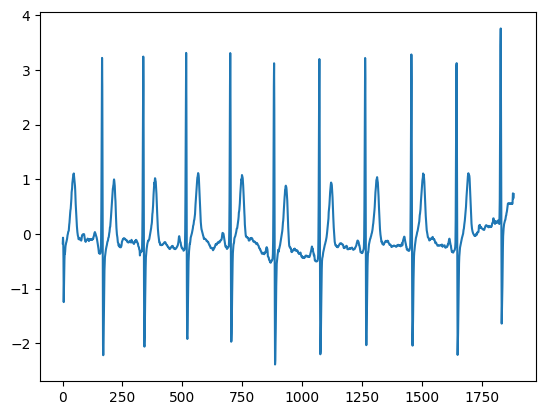

In [438]:
plt.plot(ECG_data.iloc[0, 1:-5]) # график экг после обработки сигнала

In [439]:
df_train = ECG_data_train.iloc[:, -5:]
df_val = ECG_data_val.iloc[:, -5:]

In [440]:
df_train

,patient_id,age,sex,height,weight
1592,4964.0,22.0,1,163.0,90.0
918,16196.0,84.0,0,NaN,NaN
122,767.0,61.0,0,183.0,83.0
684,12056.0,74.0,1,NaN,NaN
214,2452.0,60.0,1,152.0,NaN
...,...,...,...,...,...
1033,18617.0,49.0,0,NaN,NaN
1731,4102.0,64.0,1,168.0,66.0
763,10524.0,34.0,0,NaN,72.0
835,10717.0,55.0,0,NaN,NaN


In [441]:
ECG_data_train = ECG_data_train.iloc[:, :-5]
ECG_data_val = ECG_data_val.iloc[:, :-5]

In [442]:
ECG_data_train

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
1592,16603,0.109449,0.185223,0.125672,-0.151371,-0.829218,-0.622236,-0.656209,-0.655158,-0.620203,...,-0.276397,-0.271167,-0.271356,-0.278988,-0.276562,-0.365569,-0.453599,-0.369220,-0.385059,-0.441318
918,9557,-1.490900,-1.394463,-1.459593,-1.758585,-2.413724,-2.193418,-1.980952,-1.772527,-1.498688,...,1.808763,1.794004,1.791578,1.824338,1.824525,2.338546,2.856921,2.381495,2.466389,2.781295
122,1511,0.410295,0.418111,0.411441,0.385160,0.316728,0.322976,0.268045,0.196556,0.132210,...,0.429139,0.419976,0.423895,0.435734,0.434976,0.667413,0.897665,0.677479,0.718923,0.865508
684,7125,-0.121402,-0.121375,-0.120977,-0.119733,-0.114203,-0.115726,-0.117201,-0.126269,-0.128501,...,0.680528,0.667779,0.672897,0.689272,0.687265,0.994409,1.308699,1.007843,1.064270,1.265372
214,2316,0.028528,-0.025202,0.009788,0.172212,0.546162,0.536875,1.251363,2.411523,3.051960,...,-0.384466,-0.378909,-0.380860,-0.388554,-0.387973,-0.530641,-0.673326,-0.537565,-0.562936,-0.653343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,10677,1.348874,1.394465,1.405025,1.479370,1.920034,1.547778,0.474275,-0.755991,-1.562751,...,-0.187951,-0.184040,-0.186707,-0.190465,-0.189940,-0.280883,-0.378106,-0.283582,-0.301543,-0.365178
1731,18020,-0.285911,-0.265134,-0.282379,-0.365458,-0.574443,-0.503349,-0.498727,-0.482626,-0.459739,...,-0.247702,-0.239041,-0.247471,-0.255108,-0.257066,-0.526102,-0.801259,-0.535676,-0.586126,-0.763746
763,7978,-0.316812,-0.305549,-0.314139,-0.357382,-0.462342,-0.426322,-0.437142,-0.429418,-0.412790,...,-0.151037,-0.149981,-0.150161,-0.152364,-0.152745,-0.197529,-0.242362,-0.200993,-0.208471,-0.235857
835,8797,-0.897106,-0.901242,-0.897541,-0.887869,-0.862189,-0.857458,-0.841005,-0.826645,-0.800221,...,0.142141,0.140497,0.141669,0.143489,0.143677,0.191975,0.240699,0.193946,0.202788,0.233976


## N-граммы

In [43]:
import neurokit2
import sleepecg
import wfdb.processing
from nltk.util import ngrams

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from catboost import CatBoostClassifier

In [44]:
def find_peaks(ecgsignal, peak): # нахождение пиков
    return wfdb.processing.correct_peaks(ecgsignal, rpeaks,
            search_radius=36, smooth_window_size=50, peak_dir=peak)

In [45]:
def get_cycle(ecgsignal, rpeaks): # разбиение ЭКГ на циклы
    ecgsignal_split = []
    cycle = []
    rpeaks = rpeaks[::-1]
    f = True #флаг конца массива с пиками
    f1 = True #флаг вхождения первого пика
    for i in range(len(ecgsignal)):
        if f and i == rpeaks[-1]:
            if f1:
                f1 = False
                cycle = []
            else:
                ecgsignal_split.append(cycle)
                cycle = []
            rpeaks = rpeaks[:-1]
            if f and len(rpeaks) == 0:
                f = False
        cycle.append(ecgsignal[i])
    return ecgsignal_split

In [46]:
def sign(x): # возвращает знак числа
   return 1 if x > 0 else -1

In [47]:
def RTL(ecgsignal_split): # получение списка приращения амплитуд R, интервалов T, углов L
    sp = [[(i[0] - min(i[:10])), len(i), ((i[0] - min(i[:10]))/len(i))] for i in ecgsignal_split]
    s = []
    for i in range(len(sp) - 1):
        R = sp[i + 1][0] - sp[i][0]
        T = sp[i + 1][1] - sp[i][1]
        L = sp[i + 1][2] - sp[i][2]
        s.append([R, T, L])
    return s

In [48]:
def letters(data): # кодирование цикла по В.М. Успенскому
  if data[0] == 1:
    if data[1] == -1:
      return 'C'
    else:
      if data[2] == -1:
        return 'E'
      return 'A'
  else:
    if data[1] == 1:
      return 'D'
    else:
      if data[2] == 1:
        return 'B'
      return 'F'

In [49]:
def encoding(ecgsignal_split): # кодирование циклов в строку по В.М. Успенскому
    s = [[sign(i) for i in k] for k in RTL(ecgsignal_split)]
    stroka = ''
    for i in s:
        stroka += letters(i)
    return stroka

In [50]:
def counter_and_sort(arr): # считает и сортирует н-граммы
  quantity = {}
  for i in arr:
    if i in quantity:
      quantity[i] += 1
    else:
      quantity[i] = 1
  quantity = pd.Series(list(quantity.values()), index=list(quantity.keys())).sort_values(ascending=False)
  return quantity

In [94]:
def func(ng):  # возвращает список количества н-грамм, относящихся к каждой категории
    # н-граммы, встречающиеся только в этой категории
    ng_healthy = sum(list(map(lambda x: 1 if x in only_healthy else 0, ng))) 
    ng_sick = sum(list(map(lambda x: 1 if x in only_sick else 0, ng)))
    
    ng_septal_0 = sum(list(map(lambda x: 1 if x in only_septal_0 else 0, ng)))
    ng_septal_1 = sum(list(map(lambda x: 1 if x in only_septal_1 else 0, ng)))
    
    ng_front_0 = sum(list(map(lambda x: 1 if x in only_front_0 else 0, ng)))
    ng_front_1 = sum(list(map(lambda x: 1 if x in only_front_1 else 0, ng)))
    
    ng_side_0 = sum(list(map(lambda x: 1 if x in only_side_0 else 0, ng)))
    ng_side_1 = sum(list(map(lambda x: 1 if x in only_side_1 else 0, ng)))
    
    ng_front_side_0 = sum(list(map(lambda x: 1 if x in only_front_side_0 else 0, ng)))
    ng_front_side_1 = sum(list(map(lambda x: 1 if x in only_front_side_1 else 0, ng)))
    
    ng_front_septal_0 = sum(list(map(lambda x: 1 if x in only_front_septal_0 else 0, ng)))
    ng_front_septal_1 = sum(list(map(lambda x: 1 if x in only_front_septal_1 else 0, ng)))
    
    ng_lower_0 = sum(list(map(lambda x: 1 if x in only_lower_0 else 0, ng)))
    ng_lower_1 = sum(list(map(lambda x: 1 if x in only_lower_1 else 0, ng)))
    
    # н-граммы, которые чаще всего встречаются в этой и не встречаются в противоположной категории
    ng_popular_healthy = sum(list(map(lambda x: 1 if x in popular_healthy_only else 0, ng)))
    ng_popular_sick = sum(list(map(lambda x: 1 if x in popular_sick_only else 0, ng)))
    
    ng_popular_septal_0 = sum(list(map(lambda x: 1 if x in popular_septal_0_only else 0, ng)))
    ng_popular_septal_1 = sum(list(map(lambda x: 1 if x in popular_septal_1_only else 0, ng)))
    
    ng_popular_front_0 = sum(list(map(lambda x: 1 if x in popular_front_0_only else 0, ng)))
    ng_popular_front_1 = sum(list(map(lambda x: 1 if x in popular_front_1_only else 0, ng)))
    
    ng_popular_side_0 = sum(list(map(lambda x: 1 if x in popular_side_0_only else 0, ng)))
    ng_popular_side_1 = sum(list(map(lambda x: 1 if x in popular_side_1_only else 0, ng)))
    
    ng_popular_front_side_0 = sum(list(map(lambda x: 1 if x in popular_front_side_0_only else 0, ng)))
    ng_popular_front_side_1 = sum(list(map(lambda x: 1 if x in popular_front_side_1_only else 0, ng)))
    
    ng_popular_front_septal_0 = sum(list(map(lambda x: 1 if x in popular_front_septal_0_only else 0, ng)))
    ng_popular_front_septal_1 = sum(list(map(lambda x: 1 if x in popular_front_septal_1_only else 0, ng)))
    
    ng_popular_lower_0 = sum(list(map(lambda x: 1 if x in popular_lower_0_only else 0, ng)))
    ng_popular_lower_1 = sum(list(map(lambda x: 1 if x in popular_lower_1_only else 0, ng)))
    
    return array([[ng_healthy, ng_popular_healthy, ng_sick, ng_popular_sick],
                  [ng_septal_0, ng_popular_septal_0, ng_septal_1, ng_popular_septal_1],
                  [ng_front_0, ng_popular_front_0, ng_front_1, ng_popular_front_1],
                  [ng_side_0, ng_popular_side_0, ng_side_1, ng_popular_side_1],
                  [ng_front_side_0, ng_popular_front_side_0, ng_front_side_1, ng_popular_front_side_1],
                  [ng_front_septal_0, ng_popular_front_septal_0, ng_front_septal_1, ng_popular_front_septal_1],
                  [ng_lower_0, ng_popular_lower_0, ng_lower_1, ng_popular_lower_1]])

In [72]:
def sp_n_gramms(ngramma):  # получение н-грамм
    sp = []
    for i in ngramma:
        n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 6))))
        for k in n:
            sp.append(k)
    return sp

In [52]:
ECG_data_array_train = np.array(ECG_data_train)

In [53]:
R_Peaks_train = []

In [54]:
ecg_ids_train = []
encoding_ecgs_train = []

In [55]:
for ecgsignal in ECG_data_array_train: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_train.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_train.append(ecg_id)
    encoding_ecgs_train.append(encoding_ecg)

In [62]:
encoding_ecg_train = pd.DataFrame(columns=['encoding_ecg', 'ecg_id', 'перегородочный', 'передний', 'боковой',
                                           'передне-боковой','передне-перегородочный', 'нижний', 'норма'])
encoding_ecg_train.encoding_ecg = encoding_ecgs_train
encoding_ecg_train.ecg_id = ecg_ids_train
encoding_ecg_train = encoding_ecg_train.sort_values(by='ecg_id')
encoding_ecg_train[['перегородочный', 'передний', 'боковой',
                    'передне-боковой','передне-перегородочный', 'нижний', 'норма']] = array(myocard_train)
encoding_ecg_train

,encoding_ecg,ecg_id,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1027,DDCADDCC,9.0,0,0,0,0,0,0,1
189,BFABCFADDEC,43.0,0,0,0,0,0,0,1
1064,DDEFBCCBCCF,52.0,0,0,0,0,0,0,1
43,DDCADBCDD,57.0,0,0,0,0,0,0,1
1110,FFCCFDCFDA,96.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
365,EBDCEBDCEB,21756.0,0,0,0,0,0,0,1
181,BCEFCCDDFAF,21774.0,0,0,0,0,0,0,1
344,AEDDDCCD,21775.0,0,0,0,0,0,0,1
1389,ECCDDDECB,21825.0,0,1,0,0,0,0,0


In [66]:
encoding_ecg_train.норма.sum()

1269

In [67]:
healthy = encoding_ecg_train[encoding_ecg_train['норма'] == 1].encoding_ecg  # закодированные кардиограммы по категориям
sick = encoding_ecg_train[encoding_ecg_train['норма'] == 0].encoding_ecg

septal_0 = encoding_ecg_train[encoding_ecg_train['перегородочный'] == 0].encoding_ecg
septal_1 = encoding_ecg_train[encoding_ecg_train['перегородочный'] == 1].encoding_ecg

front_0 = encoding_ecg_train[encoding_ecg_train['передний'] == 0].encoding_ecg
front_1 = encoding_ecg_train[encoding_ecg_train['передний'] == 1].encoding_ecg

side_0 = encoding_ecg_train[encoding_ecg_train['боковой'] == 0].encoding_ecg
side_1 = encoding_ecg_train[encoding_ecg_train['боковой'] == 1].encoding_ecg

front_side_0 = encoding_ecg_train[encoding_ecg_train['передне-боковой'] == 0].encoding_ecg
front_side_1 = encoding_ecg_train[encoding_ecg_train['передне-боковой'] == 1].encoding_ecg

front_septal_0 = encoding_ecg_train[encoding_ecg_train['передне-перегородочный'] == 0].encoding_ecg
front_septal_1 = encoding_ecg_train[encoding_ecg_train['передне-перегородочный'] == 1].encoding_ecg

lower_0 = encoding_ecg_train[encoding_ecg_train['нижний'] == 0].encoding_ecg
lower_1 = encoding_ecg_train[encoding_ecg_train['нижний'] == 1].encoding_ecg

In [68]:
healthy

1027        DDCADDCC
189      BFABCFADDEC
1064     DDEFBCCBCCF
43         DDCADBCDD
1110      FFCCFDCFDA
            ...     
144      DCCDDCFEDCC
365       EBDCEBDCEB
181      BCEFCCDDFAF
344         AEDDDCCD
354     DAFCCDDDCFCD
Name: encoding_ecg, Length: 1269, dtype: object

In [71]:
sp_healthy = sp_n_gramms(healthy)  # списки н-грамм
sp_sick = sp_n_gramms(sick)

sp_septal_0 = sp_n_gramms(septal_0)
sp_septal_1 = sp_n_gramms(septal_1)

sp_front_0 = sp_n_gramms(front_0)
sp_front_1 = sp_n_gramms(front_1)

sp_side_0 = sp_n_gramms(side_0)
sp_side_1 = sp_n_gramms(side_1)

sp_front_side_0 = sp_n_gramms(front_side_0)
sp_front_side_1 = sp_n_gramms(front_side_1)

sp_front_septal_0 = sp_n_gramms(front_septal_0)
sp_front_septal_1 = sp_n_gramms(front_septal_1)

sp_lower_0 = sp_n_gramms(lower_0)
sp_lower_1 = sp_n_gramms(lower_1)

In [78]:
q_healthy = counter_and_sort(sp_healthy)  # отсортированные н-граммы
q_sick = counter_and_sort(sp_sick)

q_septal_0 = counter_and_sort(sp_septal_0)
q_septal_1 = counter_and_sort(sp_septal_1)

q_front_0 = counter_and_sort(sp_front_0)
q_front_1 = counter_and_sort(sp_front_1)

q_side_0 = counter_and_sort(sp_side_0)
q_side_1 = counter_and_sort(sp_side_1)

q_front_side_0 = counter_and_sort(sp_front_side_0)
q_front_side_1 = counter_and_sort(sp_front_side_1)

q_front_septal_0 = counter_and_sort(sp_front_septal_0)
q_front_septal_1 = counter_and_sort(sp_front_septal_1)

q_lower_0 = counter_and_sort(sp_lower_0)
q_lower_1 = counter_and_sort(sp_lower_1)

In [79]:
q_lower_1

CAFCCD    2
DBCDEB    2
CCDCDC    2
DCCDDC    2
FDCFCA    2
         ..
DFDCFC    1
DCFCAC    1
FEADEC    1
EADECB    1
CDBEBD    1
Length: 678, dtype: int64

In [80]:
only_sick = list(set(q_sick.index) - set(q_healthy.index))  # н-граммы, встречающиеся только в этой категории 
only_healthy = list(set(q_healthy.index) - set(q_sick.index))

only_septal_0 = list(set(q_septal_0.index) - set(q_septal_1.index))
only_septal_1 = list(set(q_septal_1.index) - set(q_septal_0.index))

only_front_0 = list(set(q_front_0.index) - set(q_front_1.index))
only_front_1 = list(set(q_front_1.index) - set(q_front_0.index))

only_side_0 = list(set(q_side_0.index) - set(q_side_1.index))
only_side_1 = list(set(q_side_1.index) - set(q_side_0.index))

only_front_side_0 = list(set(q_front_side_0.index) - set(q_front_side_1.index))
only_front_side_1 = list(set(q_front_side_1.index) - set(q_front_side_0.index))

only_front_septal_0 = list(set(q_front_septal_0.index) - set(q_front_septal_1.index))
only_front_septal_1 = list(set(q_front_septal_1.index) - set(q_front_septal_0.index))

only_lower_0 = list(set(q_lower_0.index) - set(q_lower_1.index))
only_lower_1 = list(set(q_lower_1.index) - set(q_lower_0.index))

In [82]:
popular_sick = q_sick.iloc[:len(q_sick) // 2]  # н-граммы, чаще всего встречающиеся в этой категории
popular_healthy = q_healthy.iloc[:len(q_healthy) // 2]

popular_septal_0 = q_septal_0.iloc[:len(q_septal_0) // 2]
popular_septal_1 = q_septal_1.iloc[:len(q_septal_1) // 2]

popular_front_0 = q_front_0.iloc[:len(q_front_0) // 2]
popular_front_1 = q_front_1.iloc[:len(q_front_1) // 2]

popular_side_0 = q_side_0.iloc[:len(q_side_0) // 2]
popular_side_1 = q_side_1.iloc[:len(q_side_1) // 2]

popular_front_side_0 = q_front_side_0.iloc[:len(q_front_side_0) // 2]
popular_front_side_1 = q_front_side_1.iloc[:len(q_front_side_1) // 2]

popular_front_septal_0 = q_front_septal_0.iloc[:len(q_front_septal_0) // 2]
popular_front_septal_1 = q_front_septal_1.iloc[:len(q_front_septal_1) // 2]

popular_lower_0 = q_lower_0.iloc[:len(q_lower_0) // 2]
popular_lower_1 = q_lower_1.iloc[:len(q_lower_1) // 2]

In [84]:
# н-граммы, которые чаще всего встречаются в этой и не встречаются в противоположной категории
popular_sick_only = list(set(popular_sick.index) - set(popular_healthy.index))
popular_healthy_only = list(set(popular_healthy.index) - set(popular_sick.index))

popular_septal_0_only = list(set(popular_septal_0.index) - set(popular_septal_1.index))
popular_septal_1_only = list(set(popular_septal_1.index) - set(popular_septal_0.index))

popular_front_0_only = list(set(popular_front_0.index) - set(popular_front_1.index))
popular_front_1_only = list(set(popular_front_1.index) - set(popular_front_0.index))

popular_side_0_only = list(set(popular_side_0.index) - set(popular_side_1.index))
popular_side_1_only = list(set(popular_side_1.index) - set(popular_side_0.index))

popular_front_side_0_only = list(set(popular_front_side_0.index) - set(popular_front_side_1.index))
popular_front_side_1_only = list(set(popular_front_side_1.index) - set(popular_front_side_0.index))

popular_front_septal_0_only = list(set(popular_front_septal_0.index) - set(popular_front_septal_1.index))
popular_front_septal_1_only = list(set(popular_front_septal_1.index) - set(popular_front_septal_0.index))

popular_lower_0_only = list(set(popular_lower_0.index) - set(popular_lower_1.index))
popular_lower_1_only = list(set(popular_lower_1.index) - set(popular_lower_0.index))

In [87]:
ngramms_ecgs_train = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_train):
    ngramms_ecg = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 6))))
    for k in n:
        ngramms_ecg.add(k)
    ngramms_ecgs_train.append(list(ngramms_ecg))

In [88]:
ngramms_ecgs_train

[['DCADDC', 'CADDCC', 'DDCADD'],
 ['BCFADD', 'BFABCF', 'FABCFA', 'FADDEC', 'CFADDE', 'ABCFAD'],
 ['DDEFBC', 'DEFBCC', 'BCCBCC', 'EFBCCB', 'CCBCCF', 'FBCCBC'],
 ['DCADBC', 'CADBCD', 'ADBCDD', 'DDCADB'],
 ['CFDCFD', 'FCCFDC', 'CCFDCF', 'FDCFDA', 'FFCCFD'],
 ['FFCCCD',
  'FCCCDC',
  'FCCFFC',
  'CFFCCF',
  'CFFCCC',
  'CDDDEC',
  'DECFFC',
  'CCFFCC',
  'DDDECF',
  'FFCCFF',
  'ECFFCC',
  'DDECFF',
  'CCDDDE'],
 ['CCDDCD', 'DDCDDC', 'CDDCDD', 'DCDDCF', 'DCCDDC'],
 ['DABDCD',
  'CDAADD',
  'ABDCDA',
  'DCDABD',
  'BDCDAA',
  'DCDAAD',
  'DAADDB',
  'CDABDC'],
 ['CFCCFD', 'DCFCCF', 'CCFDDE', 'CFDDEE', 'FCCFDD', 'DDCFCC'],
 [],
 ['DCDCFC', 'CCFDCD', 'FDCDCF', 'CFDCDC'],
 [],
 ['FCFCDC', 'CFCDCA', 'CDCAFF', 'CAFFFC', 'FCDCAF', 'AFFFCC', 'DCAFFF'],
 ['FCCFAE', 'CFCCFA', 'CCFAED', 'CFAEDC'],
 ['CBFCFD',
  'FCFDCD',
  'CFDCDC',
  'FDBCBF',
  'DBCBFC',
  'BCBFCF',
  'BFCFDC',
  'FDCDCC'],
 [],
 ['BCCDDC', 'CDBCCD', 'DBCCDD', 'CCDDCC'],
 ['CCBBDE', 'DEBBBD', 'EBBBDC', 'BDEBBB', 'CBBDEB', 'BBDEBB']

In [96]:
df_healthy = pd.DataFrame([func(ng)[0] for ng in ngramms_ecgs_train])
df_septal = pd.DataFrame([func(ng)[1] for ng in ngramms_ecgs_train])
df_front = pd.DataFrame([func(ng)[2] for ng in ngramms_ecgs_train])
df_side = pd.DataFrame([func(ng)[3] for ng in ngramms_ecgs_train])
df_front_side = pd.DataFrame([func(ng)[4] for ng in ngramms_ecgs_train])
df_front_septal = pd.DataFrame([func(ng)[5] for ng in ngramms_ecgs_train])
df_lower = pd.DataFrame([func(ng)[6] for ng in ngramms_ecgs_train])

In [98]:
df_septal

,0,1,2,3
0,3.0,3.0,0.0,0.0
1,6.0,6.0,0.0,0.0
2,6.0,6.0,0.0,0.0
3,4.0,4.0,0.0,0.0
4,5.0,5.0,0.0,0.0
...,...,...,...,...
1570,4.0,4.0,0.0,0.0
1571,6.0,6.0,0.0,0.0
1572,3.0,3.0,0.0,0.0
1573,4.0,4.0,0.0,0.0


In [259]:
X_train_healthy, X_test_healthy, y_train_healthy, y_test_healthy = train_test_split(df_healthy,
                                                                    myocard_train['норма'], random_state=0, test_size=0.8)

X_train_septal, X_test_septal, y_train_septal, y_test_septal = train_test_split(df_septal, myocard_train['перегородочный'],
                                                                                random_state=0, test_size=0.35)

X_train_front, X_test_front, y_train_front, y_test_front = train_test_split(df_front, myocard_train['передний'],
                                                                            random_state=0, test_size=0.7)

X_train_side, X_test_side, y_train_side, y_test_side = train_test_split(df_side, myocard_train['боковой'], random_state=0)

X_train_front_side, X_test_front_side, y_train_front_side, y_test_front_side = train_test_split(df_front_side,
                                                                    myocard_train['передне-боковой'], random_state=0,
                                                                                               test_size=0.1)

X_train_front_septal, X_test_front_septal, y_train_front_septal, y_test_front_septal = train_test_split(df_front_septal,
                                                                    myocard_train['передне-перегородочный'], random_state=0,
                                                                                                       test_size=0.2)

X_train_lower, X_test_lower, y_train_lower, y_test_lower = train_test_split(df_lower, myocard_train['нижний'],
                                                                            random_state=0, test_size=0.45)

In [107]:
X_train_front

,0,1,2,3
473,4.0,3.0,0.0,0.0
1202,3.0,1.0,0.0,0.0
58,2.0,2.0,0.0,0.0
241,4.0,4.0,0.0,0.0
414,0.0,0.0,0.0,0.0
...,...,...,...,...
763,4.0,3.0,0.0,1.0
835,11.0,3.0,0.0,0.0
1216,6.0,6.0,0.0,0.0
559,0.0,0.0,0.0,0.0


In [154]:
cat_n_gramms_healthy = CatBoostClassifier()
cat_n_gramms_healthy.fit(X_train_healthy, y_train_healthy)

Learning rate set to 0.006291
0:	learn: 0.6849183	total: 3.24ms	remaining: 3.23s
1:	learn: 0.6790987	total: 7.09ms	remaining: 3.54s
2:	learn: 0.6679543	total: 13.1ms	remaining: 4.34s
3:	learn: 0.6560028	total: 17.6ms	remaining: 4.38s
4:	learn: 0.6455206	total: 23.1ms	remaining: 4.6s
5:	learn: 0.6372692	total: 28.6ms	remaining: 4.74s
6:	learn: 0.6305235	total: 33ms	remaining: 4.69s
7:	learn: 0.6234622	total: 39ms	remaining: 4.84s
8:	learn: 0.6137761	total: 44.3ms	remaining: 4.87s
9:	learn: 0.6065199	total: 49.8ms	remaining: 4.93s
10:	learn: 0.5982738	total: 55.4ms	remaining: 4.98s
11:	learn: 0.5912678	total: 59.7ms	remaining: 4.91s
12:	learn: 0.5814202	total: 65.2ms	remaining: 4.95s
13:	learn: 0.5752336	total: 70.1ms	remaining: 4.93s
14:	learn: 0.5666254	total: 75.4ms	remaining: 4.95s
15:	learn: 0.5587402	total: 80.4ms	remaining: 4.95s
16:	learn: 0.5501091	total: 85.4ms	remaining: 4.94s
17:	learn: 0.5407403	total: 89.9ms	remaining: 4.9s
18:	learn: 0.5344978	total: 93.6ms	remaining: 4.83

174:	learn: 0.1764705	total: 590ms	remaining: 2.78s
175:	learn: 0.1760766	total: 592ms	remaining: 2.77s
176:	learn: 0.1753088	total: 594ms	remaining: 2.76s
177:	learn: 0.1748325	total: 597ms	remaining: 2.76s
178:	learn: 0.1744670	total: 601ms	remaining: 2.75s
179:	learn: 0.1741046	total: 603ms	remaining: 2.75s
180:	learn: 0.1734568	total: 606ms	remaining: 2.74s
181:	learn: 0.1730896	total: 609ms	remaining: 2.73s
182:	learn: 0.1726476	total: 611ms	remaining: 2.73s
183:	learn: 0.1722767	total: 615ms	remaining: 2.73s
184:	learn: 0.1715405	total: 618ms	remaining: 2.72s
185:	learn: 0.1708202	total: 622ms	remaining: 2.72s
186:	learn: 0.1705065	total: 625ms	remaining: 2.72s
187:	learn: 0.1700942	total: 628ms	remaining: 2.71s
188:	learn: 0.1695001	total: 631ms	remaining: 2.71s
189:	learn: 0.1689585	total: 634ms	remaining: 2.7s
190:	learn: 0.1687558	total: 637ms	remaining: 2.7s
191:	learn: 0.1684311	total: 640ms	remaining: 2.69s
192:	learn: 0.1679900	total: 644ms	remaining: 2.69s
193:	learn: 0.

380:	learn: 0.1356470	total: 1.21s	remaining: 1.97s
381:	learn: 0.1355792	total: 1.21s	remaining: 1.96s
382:	learn: 0.1354348	total: 1.22s	remaining: 1.96s
383:	learn: 0.1352878	total: 1.22s	remaining: 1.96s
384:	learn: 0.1352325	total: 1.22s	remaining: 1.95s
385:	learn: 0.1352195	total: 1.23s	remaining: 1.95s
386:	learn: 0.1351255	total: 1.23s	remaining: 1.95s
387:	learn: 0.1350968	total: 1.23s	remaining: 1.95s
388:	learn: 0.1350572	total: 1.24s	remaining: 1.94s
389:	learn: 0.1350401	total: 1.24s	remaining: 1.94s
390:	learn: 0.1350075	total: 1.24s	remaining: 1.93s
391:	learn: 0.1349865	total: 1.24s	remaining: 1.93s
392:	learn: 0.1349455	total: 1.25s	remaining: 1.93s
393:	learn: 0.1349215	total: 1.25s	remaining: 1.92s
394:	learn: 0.1348798	total: 1.25s	remaining: 1.92s
395:	learn: 0.1348355	total: 1.26s	remaining: 1.92s
396:	learn: 0.1347437	total: 1.26s	remaining: 1.91s
397:	learn: 0.1347164	total: 1.26s	remaining: 1.91s
398:	learn: 0.1346937	total: 1.27s	remaining: 1.91s
399:	learn: 

561:	learn: 0.1276375	total: 1.8s	remaining: 1.4s
562:	learn: 0.1275787	total: 1.8s	remaining: 1.4s
563:	learn: 0.1275679	total: 1.81s	remaining: 1.4s
564:	learn: 0.1275614	total: 1.81s	remaining: 1.4s
565:	learn: 0.1275012	total: 1.81s	remaining: 1.39s
566:	learn: 0.1274971	total: 1.82s	remaining: 1.39s
567:	learn: 0.1274611	total: 1.82s	remaining: 1.39s
568:	learn: 0.1274477	total: 1.82s	remaining: 1.38s
569:	learn: 0.1274350	total: 1.83s	remaining: 1.38s
570:	learn: 0.1274204	total: 1.83s	remaining: 1.38s
571:	learn: 0.1273988	total: 1.83s	remaining: 1.37s
572:	learn: 0.1273741	total: 1.84s	remaining: 1.37s
573:	learn: 0.1273598	total: 1.84s	remaining: 1.36s
574:	learn: 0.1273408	total: 1.84s	remaining: 1.36s
575:	learn: 0.1273351	total: 1.84s	remaining: 1.36s
576:	learn: 0.1273137	total: 1.85s	remaining: 1.35s
577:	learn: 0.1273058	total: 1.85s	remaining: 1.35s
578:	learn: 0.1272710	total: 1.85s	remaining: 1.35s
579:	learn: 0.1272104	total: 1.86s	remaining: 1.34s
580:	learn: 0.1271

754:	learn: 0.1242018	total: 2.4s	remaining: 780ms
755:	learn: 0.1241892	total: 2.4s	remaining: 776ms
756:	learn: 0.1241858	total: 2.41s	remaining: 773ms
757:	learn: 0.1241743	total: 2.41s	remaining: 770ms
758:	learn: 0.1241636	total: 2.42s	remaining: 767ms
759:	learn: 0.1241524	total: 2.42s	remaining: 763ms
760:	learn: 0.1241399	total: 2.42s	remaining: 760ms
761:	learn: 0.1241344	total: 2.42s	remaining: 757ms
762:	learn: 0.1241221	total: 2.43s	remaining: 754ms
763:	learn: 0.1240878	total: 2.43s	remaining: 751ms
764:	learn: 0.1240841	total: 2.43s	remaining: 748ms
765:	learn: 0.1240641	total: 2.44s	remaining: 745ms
766:	learn: 0.1240539	total: 2.44s	remaining: 741ms
767:	learn: 0.1240299	total: 2.44s	remaining: 738ms
768:	learn: 0.1240239	total: 2.45s	remaining: 735ms
769:	learn: 0.1240209	total: 2.45s	remaining: 732ms
770:	learn: 0.1240151	total: 2.45s	remaining: 729ms
771:	learn: 0.1240058	total: 2.46s	remaining: 725ms
772:	learn: 0.1239967	total: 2.46s	remaining: 722ms
773:	learn: 0.

950:	learn: 0.1217773	total: 2.99s	remaining: 154ms
951:	learn: 0.1217756	total: 2.99s	remaining: 151ms
952:	learn: 0.1217545	total: 3s	remaining: 148ms
953:	learn: 0.1217340	total: 3s	remaining: 145ms
954:	learn: 0.1217324	total: 3s	remaining: 141ms
955:	learn: 0.1217231	total: 3s	remaining: 138ms
956:	learn: 0.1217186	total: 3.01s	remaining: 135ms
957:	learn: 0.1217165	total: 3.01s	remaining: 132ms
958:	learn: 0.1217074	total: 3.01s	remaining: 129ms
959:	learn: 0.1216998	total: 3.02s	remaining: 126ms
960:	learn: 0.1216786	total: 3.02s	remaining: 123ms
961:	learn: 0.1216717	total: 3.02s	remaining: 119ms
962:	learn: 0.1216700	total: 3.03s	remaining: 116ms
963:	learn: 0.1216678	total: 3.03s	remaining: 113ms
964:	learn: 0.1216460	total: 3.03s	remaining: 110ms
965:	learn: 0.1216351	total: 3.04s	remaining: 107ms
966:	learn: 0.1216279	total: 3.04s	remaining: 104ms
967:	learn: 0.1216242	total: 3.04s	remaining: 101ms
968:	learn: 0.1216020	total: 3.04s	remaining: 97.4ms
969:	learn: 0.1216007	t

In [155]:
print(f1_score(y_test_healthy, cat_n_gramms_healthy.predict(X_test_healthy), average='macro'))
print(f1_score(y_train_healthy, cat_n_gramms_healthy.predict(X_train_healthy), average='macro'))

0.9049886662766891
0.9279411764705883


In [188]:
cat_n_gramms_septal = CatBoostClassifier()
cat_n_gramms_septal.fit(X_train_septal, y_train_septal)

Learning rate set to 0.010403
0:	learn: 0.6722892	total: 3.34ms	remaining: 3.34s
1:	learn: 0.6500050	total: 6.92ms	remaining: 3.45s
2:	learn: 0.6278790	total: 10.6ms	remaining: 3.53s
3:	learn: 0.6114712	total: 16.6ms	remaining: 4.13s
4:	learn: 0.5859141	total: 23.7ms	remaining: 4.72s
5:	learn: 0.5635426	total: 29ms	remaining: 4.8s
6:	learn: 0.5444013	total: 32.4ms	remaining: 4.6s
7:	learn: 0.5269687	total: 38.2ms	remaining: 4.73s
8:	learn: 0.5094327	total: 43.1ms	remaining: 4.75s
9:	learn: 0.4938609	total: 49.6ms	remaining: 4.92s
10:	learn: 0.4776828	total: 55ms	remaining: 4.95s
11:	learn: 0.4652196	total: 61.1ms	remaining: 5.03s
12:	learn: 0.4461714	total: 66.9ms	remaining: 5.08s
13:	learn: 0.4336008	total: 72.6ms	remaining: 5.11s
14:	learn: 0.4181023	total: 78.6ms	remaining: 5.16s
15:	learn: 0.4014404	total: 83.6ms	remaining: 5.14s
16:	learn: 0.3856304	total: 88.6ms	remaining: 5.12s
17:	learn: 0.3728853	total: 93.4ms	remaining: 5.1s
18:	learn: 0.3607990	total: 98.6ms	remaining: 5.09s

206:	learn: 0.0404605	total: 796ms	remaining: 3.05s
207:	learn: 0.0403608	total: 800ms	remaining: 3.04s
208:	learn: 0.0402715	total: 804ms	remaining: 3.04s
209:	learn: 0.0401738	total: 807ms	remaining: 3.04s
210:	learn: 0.0400739	total: 811ms	remaining: 3.03s
211:	learn: 0.0399748	total: 815ms	remaining: 3.03s
212:	learn: 0.0399429	total: 818ms	remaining: 3.02s
213:	learn: 0.0398726	total: 822ms	remaining: 3.02s
214:	learn: 0.0398409	total: 826ms	remaining: 3.01s
215:	learn: 0.0397612	total: 830ms	remaining: 3.01s
216:	learn: 0.0396814	total: 833ms	remaining: 3.01s
217:	learn: 0.0396631	total: 836ms	remaining: 3s
218:	learn: 0.0396404	total: 840ms	remaining: 2.99s
219:	learn: 0.0396184	total: 843ms	remaining: 2.99s
220:	learn: 0.0395334	total: 847ms	remaining: 2.99s
221:	learn: 0.0395133	total: 851ms	remaining: 2.98s
222:	learn: 0.0394281	total: 855ms	remaining: 2.98s
223:	learn: 0.0393477	total: 859ms	remaining: 2.97s
224:	learn: 0.0393194	total: 863ms	remaining: 2.97s
225:	learn: 0.0

367:	learn: 0.0358604	total: 1.39s	remaining: 2.38s
368:	learn: 0.0358516	total: 1.39s	remaining: 2.38s
369:	learn: 0.0358488	total: 1.39s	remaining: 2.37s
370:	learn: 0.0358486	total: 1.4s	remaining: 2.37s
371:	learn: 0.0358445	total: 1.4s	remaining: 2.36s
372:	learn: 0.0358373	total: 1.4s	remaining: 2.36s
373:	learn: 0.0358158	total: 1.41s	remaining: 2.36s
374:	learn: 0.0358141	total: 1.41s	remaining: 2.35s
375:	learn: 0.0358109	total: 1.42s	remaining: 2.35s
376:	learn: 0.0357892	total: 1.42s	remaining: 2.35s
377:	learn: 0.0357867	total: 1.42s	remaining: 2.34s
378:	learn: 0.0357636	total: 1.43s	remaining: 2.34s
379:	learn: 0.0357452	total: 1.43s	remaining: 2.33s
380:	learn: 0.0357323	total: 1.44s	remaining: 2.33s
381:	learn: 0.0357152	total: 1.44s	remaining: 2.33s
382:	learn: 0.0356934	total: 1.44s	remaining: 2.33s
383:	learn: 0.0356752	total: 1.45s	remaining: 2.32s
384:	learn: 0.0356548	total: 1.45s	remaining: 2.32s
385:	learn: 0.0356391	total: 1.46s	remaining: 2.32s
386:	learn: 0.0

535:	learn: 0.0347120	total: 2s	remaining: 1.73s
536:	learn: 0.0347109	total: 2.01s	remaining: 1.73s
537:	learn: 0.0347023	total: 2.01s	remaining: 1.73s
538:	learn: 0.0347017	total: 2.02s	remaining: 1.73s
539:	learn: 0.0347007	total: 2.02s	remaining: 1.72s
540:	learn: 0.0346937	total: 2.02s	remaining: 1.72s
541:	learn: 0.0346875	total: 2.03s	remaining: 1.71s
542:	learn: 0.0346848	total: 2.03s	remaining: 1.71s
543:	learn: 0.0346846	total: 2.04s	remaining: 1.71s
544:	learn: 0.0346762	total: 2.04s	remaining: 1.7s
545:	learn: 0.0346751	total: 2.04s	remaining: 1.7s
546:	learn: 0.0346745	total: 2.05s	remaining: 1.7s
547:	learn: 0.0346707	total: 2.05s	remaining: 1.69s
548:	learn: 0.0346703	total: 2.05s	remaining: 1.69s
549:	learn: 0.0346621	total: 2.06s	remaining: 1.68s
550:	learn: 0.0346611	total: 2.06s	remaining: 1.68s
551:	learn: 0.0346582	total: 2.06s	remaining: 1.67s
552:	learn: 0.0346554	total: 2.07s	remaining: 1.67s
553:	learn: 0.0346537	total: 2.07s	remaining: 1.67s
554:	learn: 0.0346

702:	learn: 0.0342703	total: 2.61s	remaining: 1.1s
703:	learn: 0.0342675	total: 2.61s	remaining: 1.1s
704:	learn: 0.0342644	total: 2.62s	remaining: 1.09s
705:	learn: 0.0342636	total: 2.62s	remaining: 1.09s
706:	learn: 0.0342623	total: 2.62s	remaining: 1.09s
707:	learn: 0.0342625	total: 2.62s	remaining: 1.08s
708:	learn: 0.0342595	total: 2.63s	remaining: 1.08s
709:	learn: 0.0342584	total: 2.63s	remaining: 1.07s
710:	learn: 0.0342545	total: 2.63s	remaining: 1.07s
711:	learn: 0.0342515	total: 2.63s	remaining: 1.06s
712:	learn: 0.0342462	total: 2.63s	remaining: 1.06s
713:	learn: 0.0342448	total: 2.64s	remaining: 1.06s
714:	learn: 0.0342443	total: 2.64s	remaining: 1.05s
715:	learn: 0.0342446	total: 2.65s	remaining: 1.05s
716:	learn: 0.0342439	total: 2.65s	remaining: 1.05s
717:	learn: 0.0342441	total: 2.65s	remaining: 1.04s
718:	learn: 0.0342429	total: 2.66s	remaining: 1.04s
719:	learn: 0.0342418	total: 2.66s	remaining: 1.03s
720:	learn: 0.0342386	total: 2.66s	remaining: 1.03s
721:	learn: 0.

867:	learn: 0.0340436	total: 3.21s	remaining: 488ms
868:	learn: 0.0340423	total: 3.21s	remaining: 484ms
869:	learn: 0.0340408	total: 3.21s	remaining: 480ms
870:	learn: 0.0340399	total: 3.22s	remaining: 477ms
871:	learn: 0.0340390	total: 3.22s	remaining: 473ms
872:	learn: 0.0340389	total: 3.22s	remaining: 469ms
873:	learn: 0.0340370	total: 3.23s	remaining: 465ms
874:	learn: 0.0340363	total: 3.23s	remaining: 462ms
875:	learn: 0.0340357	total: 3.23s	remaining: 458ms
876:	learn: 0.0340350	total: 3.24s	remaining: 454ms
877:	learn: 0.0340340	total: 3.24s	remaining: 451ms
878:	learn: 0.0340316	total: 3.25s	remaining: 447ms
879:	learn: 0.0340303	total: 3.25s	remaining: 443ms
880:	learn: 0.0340285	total: 3.25s	remaining: 440ms
881:	learn: 0.0340267	total: 3.26s	remaining: 436ms
882:	learn: 0.0340259	total: 3.26s	remaining: 432ms
883:	learn: 0.0340251	total: 3.27s	remaining: 428ms
884:	learn: 0.0340246	total: 3.27s	remaining: 425ms
885:	learn: 0.0340237	total: 3.27s	remaining: 421ms
886:	learn: 

In [189]:
print(f1_score(y_test_septal, cat_n_gramms_septal.predict(X_test_septal), average='macro'))
print(f1_score(y_train_septal, cat_n_gramms_septal.predict(X_train_septal), average='macro'))

0.933395004625347
0.9059098852360172


In [211]:
cat_n_gramms_front = CatBoostClassifier()
cat_n_gramms_front.fit(X_train_front, y_train_front)

Learning rate set to 0.007477
0:	learn: 0.6791487	total: 1.22ms	remaining: 1.22s
1:	learn: 0.6646776	total: 2.21ms	remaining: 1.1s
2:	learn: 0.6510726	total: 3.61ms	remaining: 1.2s
3:	learn: 0.6369580	total: 5.67ms	remaining: 1.41s
4:	learn: 0.6197069	total: 9.52ms	remaining: 1.89s
5:	learn: 0.6067603	total: 11.6ms	remaining: 1.92s
6:	learn: 0.5946554	total: 14.5ms	remaining: 2.05s
7:	learn: 0.5843083	total: 16.6ms	remaining: 2.06s
8:	learn: 0.5724856	total: 21.5ms	remaining: 2.37s
9:	learn: 0.5601910	total: 27ms	remaining: 2.67s
10:	learn: 0.5486550	total: 31.9ms	remaining: 2.86s
11:	learn: 0.5359493	total: 35.7ms	remaining: 2.94s
12:	learn: 0.5209760	total: 41.6ms	remaining: 3.16s
13:	learn: 0.5122665	total: 45.5ms	remaining: 3.21s
14:	learn: 0.5023819	total: 50.9ms	remaining: 3.34s
15:	learn: 0.4925840	total: 56.7ms	remaining: 3.48s
16:	learn: 0.4812306	total: 62.4ms	remaining: 3.6s
17:	learn: 0.4714280	total: 67.7ms	remaining: 3.69s
18:	learn: 0.4598183	total: 73.2ms	remaining: 3.7

181:	learn: 0.0735296	total: 599ms	remaining: 2.69s
182:	learn: 0.0733058	total: 600ms	remaining: 2.68s
183:	learn: 0.0731550	total: 601ms	remaining: 2.67s
184:	learn: 0.0729439	total: 603ms	remaining: 2.65s
185:	learn: 0.0728001	total: 604ms	remaining: 2.64s
186:	learn: 0.0726239	total: 605ms	remaining: 2.63s
187:	learn: 0.0723468	total: 607ms	remaining: 2.62s
188:	learn: 0.0720447	total: 609ms	remaining: 2.61s
189:	learn: 0.0717187	total: 612ms	remaining: 2.61s
190:	learn: 0.0715550	total: 614ms	remaining: 2.6s
191:	learn: 0.0713678	total: 617ms	remaining: 2.6s
192:	learn: 0.0711757	total: 620ms	remaining: 2.59s
193:	learn: 0.0709277	total: 624ms	remaining: 2.59s
194:	learn: 0.0707417	total: 628ms	remaining: 2.59s
195:	learn: 0.0705539	total: 631ms	remaining: 2.59s
196:	learn: 0.0702997	total: 634ms	remaining: 2.58s
197:	learn: 0.0701348	total: 637ms	remaining: 2.58s
198:	learn: 0.0699691	total: 641ms	remaining: 2.58s
199:	learn: 0.0698134	total: 644ms	remaining: 2.57s
200:	learn: 0.

384:	learn: 0.0562623	total: 1.19s	remaining: 1.9s
385:	learn: 0.0562521	total: 1.19s	remaining: 1.9s
386:	learn: 0.0562411	total: 1.2s	remaining: 1.89s
387:	learn: 0.0561927	total: 1.2s	remaining: 1.89s
388:	learn: 0.0561771	total: 1.2s	remaining: 1.89s
389:	learn: 0.0561691	total: 1.21s	remaining: 1.89s
390:	learn: 0.0561503	total: 1.21s	remaining: 1.88s
391:	learn: 0.0561148	total: 1.21s	remaining: 1.88s
392:	learn: 0.0560803	total: 1.22s	remaining: 1.88s
393:	learn: 0.0560703	total: 1.22s	remaining: 1.87s
394:	learn: 0.0560623	total: 1.22s	remaining: 1.87s
395:	learn: 0.0560533	total: 1.22s	remaining: 1.87s
396:	learn: 0.0560434	total: 1.23s	remaining: 1.86s
397:	learn: 0.0560164	total: 1.23s	remaining: 1.86s
398:	learn: 0.0560078	total: 1.23s	remaining: 1.86s
399:	learn: 0.0559737	total: 1.24s	remaining: 1.86s
400:	learn: 0.0559640	total: 1.24s	remaining: 1.85s
401:	learn: 0.0559498	total: 1.24s	remaining: 1.85s
402:	learn: 0.0559363	total: 1.25s	remaining: 1.85s
403:	learn: 0.055

579:	learn: 0.0535105	total: 1.79s	remaining: 1.3s
580:	learn: 0.0535084	total: 1.79s	remaining: 1.29s
581:	learn: 0.0534961	total: 1.79s	remaining: 1.29s
582:	learn: 0.0534929	total: 1.8s	remaining: 1.28s
583:	learn: 0.0534716	total: 1.8s	remaining: 1.28s
584:	learn: 0.0534657	total: 1.8s	remaining: 1.28s
585:	learn: 0.0534619	total: 1.81s	remaining: 1.27s
586:	learn: 0.0534594	total: 1.81s	remaining: 1.27s
587:	learn: 0.0534567	total: 1.81s	remaining: 1.27s
588:	learn: 0.0534530	total: 1.81s	remaining: 1.27s
589:	learn: 0.0534335	total: 1.82s	remaining: 1.26s
590:	learn: 0.0534320	total: 1.82s	remaining: 1.26s
591:	learn: 0.0534209	total: 1.82s	remaining: 1.26s
592:	learn: 0.0534071	total: 1.83s	remaining: 1.25s
593:	learn: 0.0534045	total: 1.83s	remaining: 1.25s
594:	learn: 0.0534006	total: 1.83s	remaining: 1.25s
595:	learn: 0.0533982	total: 1.84s	remaining: 1.25s
596:	learn: 0.0533927	total: 1.84s	remaining: 1.24s
597:	learn: 0.0533903	total: 1.84s	remaining: 1.24s
598:	learn: 0.05

773:	learn: 0.0524816	total: 2.38s	remaining: 695ms
774:	learn: 0.0524741	total: 2.38s	remaining: 692ms
775:	learn: 0.0524695	total: 2.38s	remaining: 689ms
776:	learn: 0.0524613	total: 2.39s	remaining: 686ms
777:	learn: 0.0524563	total: 2.39s	remaining: 683ms
778:	learn: 0.0524555	total: 2.4s	remaining: 680ms
779:	learn: 0.0524528	total: 2.4s	remaining: 677ms
780:	learn: 0.0524497	total: 2.4s	remaining: 674ms
781:	learn: 0.0524474	total: 2.41s	remaining: 671ms
782:	learn: 0.0524447	total: 2.41s	remaining: 668ms
783:	learn: 0.0524438	total: 2.41s	remaining: 665ms
784:	learn: 0.0524366	total: 2.42s	remaining: 662ms
785:	learn: 0.0524361	total: 2.42s	remaining: 659ms
786:	learn: 0.0524292	total: 2.42s	remaining: 656ms
787:	learn: 0.0524283	total: 2.43s	remaining: 653ms
788:	learn: 0.0524229	total: 2.43s	remaining: 650ms
789:	learn: 0.0524184	total: 2.43s	remaining: 647ms
790:	learn: 0.0524139	total: 2.44s	remaining: 644ms
791:	learn: 0.0524110	total: 2.44s	remaining: 641ms
792:	learn: 0.0

966:	learn: 0.0519207	total: 2.98s	remaining: 102ms
967:	learn: 0.0519153	total: 2.98s	remaining: 98.5ms
968:	learn: 0.0519113	total: 2.98s	remaining: 95.4ms
969:	learn: 0.0519090	total: 2.98s	remaining: 92.3ms
970:	learn: 0.0519094	total: 2.99s	remaining: 89.2ms
971:	learn: 0.0519073	total: 2.99s	remaining: 86.1ms
972:	learn: 0.0519057	total: 2.99s	remaining: 83.1ms
973:	learn: 0.0519038	total: 3s	remaining: 80ms
974:	learn: 0.0519016	total: 3s	remaining: 76.9ms
975:	learn: 0.0519001	total: 3s	remaining: 73.8ms
976:	learn: 0.0518953	total: 3s	remaining: 70.8ms
977:	learn: 0.0518899	total: 3.01s	remaining: 67.7ms
978:	learn: 0.0518888	total: 3.01s	remaining: 64.6ms
979:	learn: 0.0518854	total: 3.02s	remaining: 61.5ms
980:	learn: 0.0518849	total: 3.02s	remaining: 58.5ms
981:	learn: 0.0518828	total: 3.02s	remaining: 55.4ms
982:	learn: 0.0518812	total: 3.02s	remaining: 52.3ms
983:	learn: 0.0518767	total: 3.03s	remaining: 49.2ms
984:	learn: 0.0518712	total: 3.03s	remaining: 46.1ms
985:	lea

In [212]:
print(f1_score(y_test_front, cat_n_gramms_front.predict(X_test_front), average='macro'))
print(f1_score(y_train_front, cat_n_gramms_front.predict(X_train_front), average='macro'))

0.9212199128633669
0.9084680025856496


In [245]:
cat_n_gramms_side = CatBoostClassifier()
cat_n_gramms_side.fit(X_train_side, y_train_side)

Learning rate set to 0.011061
0:	learn: 0.6591722	total: 1.69ms	remaining: 1.68s
1:	learn: 0.6287866	total: 4.6ms	remaining: 2.3s
2:	learn: 0.5956924	total: 7.29ms	remaining: 2.42s
3:	learn: 0.5643620	total: 11ms	remaining: 2.73s
4:	learn: 0.5354876	total: 15.5ms	remaining: 3.08s
5:	learn: 0.5094388	total: 21.9ms	remaining: 3.63s
6:	learn: 0.4847110	total: 26.5ms	remaining: 3.76s
7:	learn: 0.4591378	total: 31.9ms	remaining: 3.96s
8:	learn: 0.4346167	total: 37ms	remaining: 4.08s
9:	learn: 0.4113614	total: 42.5ms	remaining: 4.2s
10:	learn: 0.3890975	total: 45.8ms	remaining: 4.11s
11:	learn: 0.3680801	total: 49.5ms	remaining: 4.08s
12:	learn: 0.3486223	total: 54.4ms	remaining: 4.13s
13:	learn: 0.3317232	total: 60.3ms	remaining: 4.25s
14:	learn: 0.3146500	total: 65.1ms	remaining: 4.27s
15:	learn: 0.2996202	total: 70.9ms	remaining: 4.36s
16:	learn: 0.2850222	total: 76.5ms	remaining: 4.42s
17:	learn: 0.2694875	total: 81.8ms	remaining: 4.46s
18:	learn: 0.2549496	total: 86.1ms	remaining: 4.45s

175:	learn: 0.0022299	total: 592ms	remaining: 2.77s
176:	learn: 0.0022032	total: 594ms	remaining: 2.76s
177:	learn: 0.0021647	total: 596ms	remaining: 2.75s
178:	learn: 0.0021353	total: 598ms	remaining: 2.74s
179:	learn: 0.0020999	total: 600ms	remaining: 2.73s
180:	learn: 0.0020639	total: 602ms	remaining: 2.73s
181:	learn: 0.0020430	total: 606ms	remaining: 2.72s
182:	learn: 0.0020121	total: 608ms	remaining: 2.72s
183:	learn: 0.0019806	total: 611ms	remaining: 2.71s
184:	learn: 0.0019575	total: 614ms	remaining: 2.71s
185:	learn: 0.0019338	total: 618ms	remaining: 2.7s
186:	learn: 0.0019108	total: 621ms	remaining: 2.7s
187:	learn: 0.0018901	total: 625ms	remaining: 2.7s
188:	learn: 0.0018663	total: 628ms	remaining: 2.7s
189:	learn: 0.0018469	total: 631ms	remaining: 2.69s
190:	learn: 0.0018190	total: 634ms	remaining: 2.69s
191:	learn: 0.0017985	total: 637ms	remaining: 2.68s
192:	learn: 0.0017705	total: 640ms	remaining: 2.67s
193:	learn: 0.0017551	total: 643ms	remaining: 2.67s
194:	learn: 0.00

395:	learn: 0.0004276	total: 1.2s	remaining: 1.84s
396:	learn: 0.0004265	total: 1.21s	remaining: 1.83s
397:	learn: 0.0004254	total: 1.21s	remaining: 1.82s
398:	learn: 0.0004230	total: 1.21s	remaining: 1.82s
399:	learn: 0.0004217	total: 1.21s	remaining: 1.82s
400:	learn: 0.0004200	total: 1.22s	remaining: 1.82s
401:	learn: 0.0004182	total: 1.22s	remaining: 1.81s
402:	learn: 0.0004167	total: 1.22s	remaining: 1.81s
403:	learn: 0.0004154	total: 1.22s	remaining: 1.8s
404:	learn: 0.0004142	total: 1.23s	remaining: 1.8s
405:	learn: 0.0004128	total: 1.23s	remaining: 1.8s
406:	learn: 0.0004116	total: 1.23s	remaining: 1.79s
407:	learn: 0.0004104	total: 1.24s	remaining: 1.79s
408:	learn: 0.0004076	total: 1.24s	remaining: 1.79s
409:	learn: 0.0004054	total: 1.24s	remaining: 1.78s
410:	learn: 0.0004042	total: 1.24s	remaining: 1.78s
411:	learn: 0.0004026	total: 1.25s	remaining: 1.78s
412:	learn: 0.0004011	total: 1.25s	remaining: 1.78s
413:	learn: 0.0004000	total: 1.25s	remaining: 1.78s
414:	learn: 0.00

599:	learn: 0.0002236	total: 1.81s	remaining: 1.2s
600:	learn: 0.0002233	total: 1.81s	remaining: 1.2s
601:	learn: 0.0002229	total: 1.81s	remaining: 1.2s
602:	learn: 0.0002219	total: 1.81s	remaining: 1.19s
603:	learn: 0.0002215	total: 1.81s	remaining: 1.19s
604:	learn: 0.0002199	total: 1.82s	remaining: 1.19s
605:	learn: 0.0002188	total: 1.82s	remaining: 1.18s
606:	learn: 0.0002181	total: 1.82s	remaining: 1.18s
607:	learn: 0.0002176	total: 1.83s	remaining: 1.18s
608:	learn: 0.0002170	total: 1.83s	remaining: 1.18s
609:	learn: 0.0002166	total: 1.83s	remaining: 1.17s
610:	learn: 0.0002160	total: 1.84s	remaining: 1.17s
611:	learn: 0.0002157	total: 1.84s	remaining: 1.17s
612:	learn: 0.0002152	total: 1.84s	remaining: 1.16s
613:	learn: 0.0002148	total: 1.85s	remaining: 1.16s
614:	learn: 0.0002142	total: 1.85s	remaining: 1.16s
615:	learn: 0.0002138	total: 1.85s	remaining: 1.15s
616:	learn: 0.0002134	total: 1.85s	remaining: 1.15s
617:	learn: 0.0002130	total: 1.86s	remaining: 1.15s
618:	learn: 0.0

789:	learn: 0.0001527	total: 2.4s	remaining: 638ms
790:	learn: 0.0001525	total: 2.4s	remaining: 635ms
791:	learn: 0.0001522	total: 2.4s	remaining: 632ms
792:	learn: 0.0001514	total: 2.4s	remaining: 628ms
793:	learn: 0.0001509	total: 2.41s	remaining: 625ms
794:	learn: 0.0001508	total: 2.41s	remaining: 622ms
795:	learn: 0.0001505	total: 2.41s	remaining: 618ms
796:	learn: 0.0001503	total: 2.42s	remaining: 615ms
797:	learn: 0.0001497	total: 2.42s	remaining: 612ms
798:	learn: 0.0001495	total: 2.42s	remaining: 609ms
799:	learn: 0.0001493	total: 2.42s	remaining: 606ms
800:	learn: 0.0001491	total: 2.42s	remaining: 603ms
801:	learn: 0.0001489	total: 2.43s	remaining: 600ms
802:	learn: 0.0001487	total: 2.43s	remaining: 597ms
803:	learn: 0.0001486	total: 2.44s	remaining: 594ms
804:	learn: 0.0001482	total: 2.44s	remaining: 591ms
805:	learn: 0.0001480	total: 2.44s	remaining: 587ms
806:	learn: 0.0001477	total: 2.44s	remaining: 584ms
807:	learn: 0.0001476	total: 2.45s	remaining: 581ms
808:	learn: 0.00

977:	learn: 0.0001142	total: 2.99s	remaining: 67.2ms
978:	learn: 0.0001139	total: 2.99s	remaining: 64.1ms
979:	learn: 0.0001138	total: 2.99s	remaining: 61.1ms
980:	learn: 0.0001137	total: 3s	remaining: 58.1ms
981:	learn: 0.0001136	total: 3s	remaining: 55ms
982:	learn: 0.0001135	total: 3s	remaining: 51.9ms
983:	learn: 0.0001134	total: 3s	remaining: 48.9ms
984:	learn: 0.0001133	total: 3.01s	remaining: 45.8ms
985:	learn: 0.0001132	total: 3.01s	remaining: 42.8ms
986:	learn: 0.0001131	total: 3.02s	remaining: 39.7ms
987:	learn: 0.0001130	total: 3.02s	remaining: 36.7ms
988:	learn: 0.0001129	total: 3.02s	remaining: 33.6ms
989:	learn: 0.0001127	total: 3.03s	remaining: 30.6ms
990:	learn: 0.0001126	total: 3.03s	remaining: 27.5ms
991:	learn: 0.0001125	total: 3.04s	remaining: 24.5ms
992:	learn: 0.0001109	total: 3.04s	remaining: 21.4ms
993:	learn: 0.0001108	total: 3.04s	remaining: 18.4ms
994:	learn: 0.0001106	total: 3.04s	remaining: 15.3ms
995:	learn: 0.0001104	total: 3.05s	remaining: 12.2ms
996:	le

In [218]:
print(f1_score(y_test_side, cat_n_gramms_side.predict(X_test_side), average='macro'))
print(f1_score(y_train_side, cat_n_gramms_side.predict(X_train_side), average='macro'))

1.0
1.0


In [246]:
cat_n_gramms_front_side = CatBoostClassifier()
cat_n_gramms_front_side.fit(X_train_front_side, y_train_front_side)

Learning rate set to 0.011956
0:	learn: 0.6588493	total: 1.61ms	remaining: 1.61s
1:	learn: 0.6320263	total: 2.74ms	remaining: 1.37s
2:	learn: 0.5994351	total: 3.72ms	remaining: 1.24s
3:	learn: 0.5750840	total: 4.99ms	remaining: 1.24s
4:	learn: 0.5464400	total: 8ms	remaining: 1.59s
5:	learn: 0.5182995	total: 12.1ms	remaining: 2s
6:	learn: 0.4984179	total: 15.8ms	remaining: 2.25s
7:	learn: 0.4728817	total: 24ms	remaining: 2.97s
8:	learn: 0.4494163	total: 31.7ms	remaining: 3.49s
9:	learn: 0.4334060	total: 37.6ms	remaining: 3.72s
10:	learn: 0.4117512	total: 44.3ms	remaining: 3.98s
11:	learn: 0.3912112	total: 50.8ms	remaining: 4.18s
12:	learn: 0.3747360	total: 56.9ms	remaining: 4.32s
13:	learn: 0.3557238	total: 62.8ms	remaining: 4.42s
14:	learn: 0.3412185	total: 67.5ms	remaining: 4.43s
15:	learn: 0.3242387	total: 72.5ms	remaining: 4.46s
16:	learn: 0.3074938	total: 77.9ms	remaining: 4.51s
17:	learn: 0.2917346	total: 83.2ms	remaining: 4.54s
18:	learn: 0.2774848	total: 88.1ms	remaining: 4.55s


200:	learn: 0.0142621	total: 805ms	remaining: 3.2s
201:	learn: 0.0142508	total: 808ms	remaining: 3.19s
202:	learn: 0.0142318	total: 812ms	remaining: 3.19s
203:	learn: 0.0142205	total: 815ms	remaining: 3.18s
204:	learn: 0.0142061	total: 819ms	remaining: 3.18s
205:	learn: 0.0141903	total: 823ms	remaining: 3.17s
206:	learn: 0.0141821	total: 826ms	remaining: 3.16s
207:	learn: 0.0141687	total: 830ms	remaining: 3.16s
208:	learn: 0.0141563	total: 835ms	remaining: 3.16s
209:	learn: 0.0141279	total: 839ms	remaining: 3.15s
210:	learn: 0.0141194	total: 843ms	remaining: 3.15s
211:	learn: 0.0141128	total: 846ms	remaining: 3.14s
212:	learn: 0.0140916	total: 850ms	remaining: 3.14s
213:	learn: 0.0140802	total: 853ms	remaining: 3.13s
214:	learn: 0.0140662	total: 857ms	remaining: 3.13s
215:	learn: 0.0140519	total: 860ms	remaining: 3.12s
216:	learn: 0.0140400	total: 864ms	remaining: 3.12s
217:	learn: 0.0140205	total: 868ms	remaining: 3.11s
218:	learn: 0.0139967	total: 871ms	remaining: 3.11s
219:	learn: 0

410:	learn: 0.0129052	total: 1.61s	remaining: 2.3s
411:	learn: 0.0129045	total: 1.61s	remaining: 2.3s
412:	learn: 0.0129035	total: 1.61s	remaining: 2.29s
413:	learn: 0.0129015	total: 1.62s	remaining: 2.29s
414:	learn: 0.0128958	total: 1.62s	remaining: 2.29s
415:	learn: 0.0128923	total: 1.63s	remaining: 2.28s
416:	learn: 0.0128922	total: 1.63s	remaining: 2.28s
417:	learn: 0.0128851	total: 1.63s	remaining: 2.27s
418:	learn: 0.0128811	total: 1.64s	remaining: 2.27s
419:	learn: 0.0128722	total: 1.64s	remaining: 2.27s
420:	learn: 0.0128653	total: 1.64s	remaining: 2.26s
421:	learn: 0.0128640	total: 1.65s	remaining: 2.26s
422:	learn: 0.0128621	total: 1.65s	remaining: 2.25s
423:	learn: 0.0128611	total: 1.66s	remaining: 2.25s
424:	learn: 0.0128553	total: 1.66s	remaining: 2.25s
425:	learn: 0.0128539	total: 1.67s	remaining: 2.24s
426:	learn: 0.0128523	total: 1.67s	remaining: 2.24s
427:	learn: 0.0128462	total: 1.67s	remaining: 2.24s
428:	learn: 0.0128444	total: 1.68s	remaining: 2.23s
429:	learn: 0.

576:	learn: 0.0126387	total: 2.22s	remaining: 1.63s
577:	learn: 0.0126373	total: 2.23s	remaining: 1.62s
578:	learn: 0.0126347	total: 2.23s	remaining: 1.62s
579:	learn: 0.0126327	total: 2.23s	remaining: 1.62s
580:	learn: 0.0126325	total: 2.24s	remaining: 1.61s
581:	learn: 0.0126276	total: 2.24s	remaining: 1.61s
582:	learn: 0.0126271	total: 2.25s	remaining: 1.61s
583:	learn: 0.0126273	total: 2.25s	remaining: 1.6s
584:	learn: 0.0126261	total: 2.25s	remaining: 1.6s
585:	learn: 0.0126223	total: 2.26s	remaining: 1.59s
586:	learn: 0.0126214	total: 2.26s	remaining: 1.59s
587:	learn: 0.0126212	total: 2.27s	remaining: 1.59s
588:	learn: 0.0126212	total: 2.27s	remaining: 1.58s
589:	learn: 0.0126200	total: 2.28s	remaining: 1.58s
590:	learn: 0.0126175	total: 2.28s	remaining: 1.58s
591:	learn: 0.0126178	total: 2.29s	remaining: 1.57s
592:	learn: 0.0126151	total: 2.29s	remaining: 1.57s
593:	learn: 0.0126117	total: 2.29s	remaining: 1.57s
594:	learn: 0.0126113	total: 2.3s	remaining: 1.56s
595:	learn: 0.0

782:	learn: 0.0124477	total: 3.02s	remaining: 838ms
783:	learn: 0.0124458	total: 3.02s	remaining: 834ms
784:	learn: 0.0124455	total: 3.03s	remaining: 830ms
785:	learn: 0.0124450	total: 3.03s	remaining: 826ms
786:	learn: 0.0124433	total: 3.04s	remaining: 822ms
787:	learn: 0.0124419	total: 3.04s	remaining: 818ms
788:	learn: 0.0124406	total: 3.05s	remaining: 815ms
789:	learn: 0.0124412	total: 3.05s	remaining: 811ms
790:	learn: 0.0124399	total: 3.05s	remaining: 807ms
791:	learn: 0.0124391	total: 3.06s	remaining: 803ms
792:	learn: 0.0124382	total: 3.06s	remaining: 799ms
793:	learn: 0.0124377	total: 3.06s	remaining: 795ms
794:	learn: 0.0124374	total: 3.07s	remaining: 791ms
795:	learn: 0.0124377	total: 3.07s	remaining: 787ms
796:	learn: 0.0124377	total: 3.08s	remaining: 784ms
797:	learn: 0.0124367	total: 3.08s	remaining: 780ms
798:	learn: 0.0124365	total: 3.08s	remaining: 776ms
799:	learn: 0.0124364	total: 3.09s	remaining: 772ms
800:	learn: 0.0124353	total: 3.09s	remaining: 768ms
801:	learn: 

986:	learn: 0.0123350	total: 3.83s	remaining: 50.4ms
987:	learn: 0.0123349	total: 3.83s	remaining: 46.5ms
988:	learn: 0.0123336	total: 3.84s	remaining: 42.7ms
989:	learn: 0.0123339	total: 3.84s	remaining: 38.8ms
990:	learn: 0.0123341	total: 3.84s	remaining: 34.9ms
991:	learn: 0.0123330	total: 3.85s	remaining: 31ms
992:	learn: 0.0123330	total: 3.85s	remaining: 27.2ms
993:	learn: 0.0123313	total: 3.86s	remaining: 23.3ms
994:	learn: 0.0123313	total: 3.86s	remaining: 19.4ms
995:	learn: 0.0123307	total: 3.87s	remaining: 15.5ms
996:	learn: 0.0123304	total: 3.87s	remaining: 11.6ms
997:	learn: 0.0123309	total: 3.87s	remaining: 7.76ms
998:	learn: 0.0123295	total: 3.88s	remaining: 3.88ms
999:	learn: 0.0123296	total: 3.88s	remaining: 0us


In [247]:
print(f1_score(y_test_front_side, cat_n_gramms_front_side.predict(X_test_front_side), average='macro'))
print(f1_score(y_train_front_side, cat_n_gramms_front_side.predict(X_train_front_side), average='macro'))

1.0
0.9566069514622568


In [234]:
cat_n_gramms_front_septal = CatBoostClassifier()
cat_n_gramms_front_septal.fit(X_train_front_septal, y_train_front_septal)

Learning rate set to 0.011371
0:	learn: 0.6714248	total: 2.21ms	remaining: 2.2s
1:	learn: 0.6529245	total: 5.9ms	remaining: 2.94s
2:	learn: 0.6253012	total: 10.5ms	remaining: 3.5s
3:	learn: 0.6059303	total: 15ms	remaining: 3.73s
4:	learn: 0.5796813	total: 20.1ms	remaining: 4.01s
5:	learn: 0.5607956	total: 27.5ms	remaining: 4.56s
6:	learn: 0.5428404	total: 34ms	remaining: 4.82s
7:	learn: 0.5265622	total: 38.4ms	remaining: 4.76s
8:	learn: 0.5100880	total: 44.4ms	remaining: 4.88s
9:	learn: 0.4952467	total: 50.4ms	remaining: 4.99s
10:	learn: 0.4806790	total: 55.9ms	remaining: 5.02s
11:	learn: 0.4666312	total: 61.3ms	remaining: 5.05s
12:	learn: 0.4563796	total: 66.6ms	remaining: 5.05s
13:	learn: 0.4448858	total: 72.5ms	remaining: 5.1s
14:	learn: 0.4321201	total: 77.6ms	remaining: 5.09s
15:	learn: 0.4148038	total: 82.5ms	remaining: 5.07s
16:	learn: 0.4034735	total: 87.6ms	remaining: 5.06s
17:	learn: 0.3919920	total: 92.9ms	remaining: 5.07s
18:	learn: 0.3811226	total: 98.9ms	remaining: 5.11s


194:	learn: 0.0603729	total: 785ms	remaining: 3.24s
195:	learn: 0.0603015	total: 786ms	remaining: 3.23s
196:	learn: 0.0602034	total: 790ms	remaining: 3.22s
197:	learn: 0.0601298	total: 794ms	remaining: 3.21s
198:	learn: 0.0600583	total: 798ms	remaining: 3.21s
199:	learn: 0.0600264	total: 802ms	remaining: 3.21s
200:	learn: 0.0599444	total: 805ms	remaining: 3.2s
201:	learn: 0.0598766	total: 809ms	remaining: 3.2s
202:	learn: 0.0598640	total: 813ms	remaining: 3.19s
203:	learn: 0.0598047	total: 818ms	remaining: 3.19s
204:	learn: 0.0597924	total: 821ms	remaining: 3.18s
205:	learn: 0.0597783	total: 825ms	remaining: 3.18s
206:	learn: 0.0597175	total: 828ms	remaining: 3.17s
207:	learn: 0.0596381	total: 833ms	remaining: 3.17s
208:	learn: 0.0595711	total: 837ms	remaining: 3.17s
209:	learn: 0.0595425	total: 841ms	remaining: 3.16s
210:	learn: 0.0594833	total: 844ms	remaining: 3.16s
211:	learn: 0.0594473	total: 847ms	remaining: 3.15s
212:	learn: 0.0594371	total: 851ms	remaining: 3.15s
213:	learn: 0.

405:	learn: 0.0560577	total: 1.59s	remaining: 2.32s
406:	learn: 0.0560569	total: 1.59s	remaining: 2.32s
407:	learn: 0.0560550	total: 1.59s	remaining: 2.31s
408:	learn: 0.0560539	total: 1.6s	remaining: 2.31s
409:	learn: 0.0560400	total: 1.6s	remaining: 2.3s
410:	learn: 0.0560305	total: 1.6s	remaining: 2.3s
411:	learn: 0.0560236	total: 1.61s	remaining: 2.29s
412:	learn: 0.0560221	total: 1.61s	remaining: 2.29s
413:	learn: 0.0560192	total: 1.62s	remaining: 2.29s
414:	learn: 0.0560182	total: 1.62s	remaining: 2.28s
415:	learn: 0.0560031	total: 1.62s	remaining: 2.28s
416:	learn: 0.0560022	total: 1.63s	remaining: 2.27s
417:	learn: 0.0559896	total: 1.63s	remaining: 2.27s
418:	learn: 0.0559768	total: 1.63s	remaining: 2.27s
419:	learn: 0.0559764	total: 1.64s	remaining: 2.26s
420:	learn: 0.0559749	total: 1.64s	remaining: 2.26s
421:	learn: 0.0559694	total: 1.65s	remaining: 2.25s
422:	learn: 0.0559601	total: 1.65s	remaining: 2.25s
423:	learn: 0.0559545	total: 1.65s	remaining: 2.25s
424:	learn: 0.055

615:	learn: 0.0552648	total: 2.38s	remaining: 1.49s
616:	learn: 0.0552610	total: 2.39s	remaining: 1.48s
617:	learn: 0.0552607	total: 2.39s	remaining: 1.48s
618:	learn: 0.0552551	total: 2.4s	remaining: 1.47s
619:	learn: 0.0552518	total: 2.4s	remaining: 1.47s
620:	learn: 0.0552482	total: 2.4s	remaining: 1.47s
621:	learn: 0.0552436	total: 2.4s	remaining: 1.46s
622:	learn: 0.0552420	total: 2.41s	remaining: 1.46s
623:	learn: 0.0552368	total: 2.41s	remaining: 1.45s
624:	learn: 0.0552351	total: 2.42s	remaining: 1.45s
625:	learn: 0.0552339	total: 2.42s	remaining: 1.45s
626:	learn: 0.0552316	total: 2.42s	remaining: 1.44s
627:	learn: 0.0552280	total: 2.43s	remaining: 1.44s
628:	learn: 0.0552241	total: 2.43s	remaining: 1.43s
629:	learn: 0.0552228	total: 2.44s	remaining: 1.43s
630:	learn: 0.0552176	total: 2.44s	remaining: 1.43s
631:	learn: 0.0552161	total: 2.44s	remaining: 1.42s
632:	learn: 0.0552161	total: 2.44s	remaining: 1.42s
633:	learn: 0.0552110	total: 2.45s	remaining: 1.41s
634:	learn: 0.05

774:	learn: 0.0548338	total: 2.98s	remaining: 866ms
775:	learn: 0.0548305	total: 2.99s	remaining: 863ms
776:	learn: 0.0548279	total: 2.99s	remaining: 859ms
777:	learn: 0.0548244	total: 3s	remaining: 855ms
778:	learn: 0.0548234	total: 3s	remaining: 851ms
779:	learn: 0.0548225	total: 3s	remaining: 847ms
780:	learn: 0.0548197	total: 3s	remaining: 843ms
781:	learn: 0.0548169	total: 3.01s	remaining: 839ms
782:	learn: 0.0548158	total: 3.01s	remaining: 835ms
783:	learn: 0.0548132	total: 3.02s	remaining: 832ms
784:	learn: 0.0548119	total: 3.02s	remaining: 828ms
785:	learn: 0.0548113	total: 3.03s	remaining: 824ms
786:	learn: 0.0548080	total: 3.03s	remaining: 821ms
787:	learn: 0.0548047	total: 3.04s	remaining: 817ms
788:	learn: 0.0548012	total: 3.04s	remaining: 813ms
789:	learn: 0.0548006	total: 3.04s	remaining: 809ms
790:	learn: 0.0547970	total: 3.05s	remaining: 805ms
791:	learn: 0.0547948	total: 3.05s	remaining: 801ms
792:	learn: 0.0547925	total: 3.05s	remaining: 797ms
793:	learn: 0.0547909	to

984:	learn: 0.0544770	total: 3.79s	remaining: 57.7ms
985:	learn: 0.0544759	total: 3.79s	remaining: 53.9ms
986:	learn: 0.0544749	total: 3.8s	remaining: 50ms
987:	learn: 0.0544737	total: 3.8s	remaining: 46.2ms
988:	learn: 0.0544727	total: 3.81s	remaining: 42.3ms
989:	learn: 0.0544719	total: 3.81s	remaining: 38.5ms
990:	learn: 0.0544698	total: 3.81s	remaining: 34.6ms
991:	learn: 0.0544691	total: 3.82s	remaining: 30.8ms
992:	learn: 0.0544682	total: 3.82s	remaining: 26.9ms
993:	learn: 0.0544673	total: 3.83s	remaining: 23.1ms
994:	learn: 0.0544670	total: 3.83s	remaining: 19.2ms
995:	learn: 0.0544646	total: 3.83s	remaining: 15.4ms
996:	learn: 0.0544636	total: 3.84s	remaining: 11.5ms
997:	learn: 0.0544627	total: 3.84s	remaining: 7.7ms
998:	learn: 0.0544618	total: 3.85s	remaining: 3.85ms
999:	learn: 0.0544611	total: 3.85s	remaining: 0us


In [235]:
print(f1_score(y_test_front_septal, cat_n_gramms_front_septal.predict(X_test_front_septal), average='macro'))
print(f1_score(y_train_front_septal, cat_n_gramms_front_septal.predict(X_train_front_septal), average='macro'))

0.9529007177033493
0.9290638175426306


In [260]:
cat_n_gramms_lower = CatBoostClassifier()
cat_n_gramms_lower.fit(X_train_lower, y_train_lower)

Learning rate set to 0.009688
0:	learn: 0.6788631	total: 3.42ms	remaining: 3.42s
1:	learn: 0.6637813	total: 6.58ms	remaining: 3.28s
2:	learn: 0.6426934	total: 8.86ms	remaining: 2.94s
3:	learn: 0.6284094	total: 12.6ms	remaining: 3.14s
4:	learn: 0.6070297	total: 19.1ms	remaining: 3.81s
5:	learn: 0.5920213	total: 25.2ms	remaining: 4.18s
6:	learn: 0.5783598	total: 30.9ms	remaining: 4.38s
7:	learn: 0.5659733	total: 36.7ms	remaining: 4.55s
8:	learn: 0.5526875	total: 42.8ms	remaining: 4.72s
9:	learn: 0.5370068	total: 49ms	remaining: 4.85s
10:	learn: 0.5196264	total: 54.5ms	remaining: 4.9s
11:	learn: 0.5087835	total: 60.3ms	remaining: 4.97s
12:	learn: 0.4996391	total: 65.7ms	remaining: 4.99s
13:	learn: 0.4882819	total: 71.7ms	remaining: 5.05s
14:	learn: 0.4781210	total: 77.2ms	remaining: 5.07s
15:	learn: 0.4649135	total: 81.7ms	remaining: 5.02s
16:	learn: 0.4504432	total: 86.6ms	remaining: 5.01s
17:	learn: 0.4396877	total: 91.9ms	remaining: 5.01s
18:	learn: 0.4256941	total: 97.4ms	remaining: 5

161:	learn: 0.1068851	total: 595ms	remaining: 3.08s
162:	learn: 0.1067700	total: 598ms	remaining: 3.07s
163:	learn: 0.1063434	total: 601ms	remaining: 3.06s
164:	learn: 0.1062161	total: 605ms	remaining: 3.06s
165:	learn: 0.1061321	total: 608ms	remaining: 3.05s
166:	learn: 0.1060046	total: 611ms	remaining: 3.05s
167:	learn: 0.1058846	total: 614ms	remaining: 3.04s
168:	learn: 0.1055407	total: 617ms	remaining: 3.04s
169:	learn: 0.1053791	total: 620ms	remaining: 3.03s
170:	learn: 0.1053088	total: 624ms	remaining: 3.02s
171:	learn: 0.1051968	total: 627ms	remaining: 3.02s
172:	learn: 0.1050047	total: 630ms	remaining: 3.01s
173:	learn: 0.1048966	total: 634ms	remaining: 3.01s
174:	learn: 0.1048359	total: 637ms	remaining: 3s
175:	learn: 0.1044484	total: 640ms	remaining: 3s
176:	learn: 0.1042789	total: 644ms	remaining: 3s
177:	learn: 0.1042221	total: 647ms	remaining: 2.99s
178:	learn: 0.1040113	total: 650ms	remaining: 2.98s
179:	learn: 0.1039173	total: 654ms	remaining: 2.98s
180:	learn: 0.1038580

342:	learn: 0.0914447	total: 1.2s	remaining: 2.29s
343:	learn: 0.0913818	total: 1.2s	remaining: 2.29s
344:	learn: 0.0913244	total: 1.2s	remaining: 2.28s
345:	learn: 0.0912802	total: 1.21s	remaining: 2.28s
346:	learn: 0.0912764	total: 1.21s	remaining: 2.28s
347:	learn: 0.0912286	total: 1.21s	remaining: 2.27s
348:	learn: 0.0912254	total: 1.22s	remaining: 2.27s
349:	learn: 0.0911816	total: 1.22s	remaining: 2.27s
350:	learn: 0.0911270	total: 1.22s	remaining: 2.26s
351:	learn: 0.0910718	total: 1.23s	remaining: 2.26s
352:	learn: 0.0910184	total: 1.23s	remaining: 2.26s
353:	learn: 0.0909896	total: 1.24s	remaining: 2.26s
354:	learn: 0.0909876	total: 1.24s	remaining: 2.25s
355:	learn: 0.0909337	total: 1.24s	remaining: 2.25s
356:	learn: 0.0909199	total: 1.25s	remaining: 2.24s
357:	learn: 0.0909138	total: 1.25s	remaining: 2.24s
358:	learn: 0.0909100	total: 1.25s	remaining: 2.24s
359:	learn: 0.0908975	total: 1.25s	remaining: 2.23s
360:	learn: 0.0908789	total: 1.26s	remaining: 2.23s
361:	learn: 0.0

523:	learn: 0.0886740	total: 1.79s	remaining: 1.63s
524:	learn: 0.0886739	total: 1.8s	remaining: 1.63s
525:	learn: 0.0886638	total: 1.8s	remaining: 1.62s
526:	learn: 0.0886629	total: 1.8s	remaining: 1.62s
527:	learn: 0.0886429	total: 1.81s	remaining: 1.61s
528:	learn: 0.0886289	total: 1.81s	remaining: 1.61s
529:	learn: 0.0886266	total: 1.81s	remaining: 1.61s
530:	learn: 0.0886193	total: 1.82s	remaining: 1.6s
531:	learn: 0.0886060	total: 1.82s	remaining: 1.6s
532:	learn: 0.0886005	total: 1.82s	remaining: 1.6s
533:	learn: 0.0885808	total: 1.83s	remaining: 1.59s
534:	learn: 0.0885586	total: 1.83s	remaining: 1.59s
535:	learn: 0.0885396	total: 1.83s	remaining: 1.59s
536:	learn: 0.0885185	total: 1.84s	remaining: 1.58s
537:	learn: 0.0885051	total: 1.84s	remaining: 1.58s
538:	learn: 0.0885023	total: 1.84s	remaining: 1.58s
539:	learn: 0.0885018	total: 1.85s	remaining: 1.57s
540:	learn: 0.0885002	total: 1.85s	remaining: 1.57s
541:	learn: 0.0884955	total: 1.85s	remaining: 1.57s
542:	learn: 0.0884

705:	learn: 0.0876078	total: 2.39s	remaining: 996ms
706:	learn: 0.0875991	total: 2.4s	remaining: 993ms
707:	learn: 0.0875976	total: 2.4s	remaining: 989ms
708:	learn: 0.0875976	total: 2.4s	remaining: 986ms
709:	learn: 0.0875957	total: 2.41s	remaining: 983ms
710:	learn: 0.0875935	total: 2.41s	remaining: 980ms
711:	learn: 0.0875890	total: 2.41s	remaining: 976ms
712:	learn: 0.0875834	total: 2.42s	remaining: 973ms
713:	learn: 0.0875765	total: 2.42s	remaining: 969ms
714:	learn: 0.0875664	total: 2.42s	remaining: 966ms
715:	learn: 0.0875665	total: 2.43s	remaining: 963ms
716:	learn: 0.0875548	total: 2.43s	remaining: 959ms
717:	learn: 0.0875518	total: 2.43s	remaining: 956ms
718:	learn: 0.0875494	total: 2.44s	remaining: 952ms
719:	learn: 0.0875476	total: 2.44s	remaining: 948ms
720:	learn: 0.0875422	total: 2.44s	remaining: 945ms
721:	learn: 0.0875407	total: 2.44s	remaining: 942ms
722:	learn: 0.0875352	total: 2.45s	remaining: 938ms
723:	learn: 0.0875307	total: 2.45s	remaining: 935ms
724:	learn: 0.0

884:	learn: 0.0869512	total: 3s	remaining: 390ms
885:	learn: 0.0869503	total: 3s	remaining: 386ms
886:	learn: 0.0869449	total: 3.01s	remaining: 383ms
887:	learn: 0.0869449	total: 3.01s	remaining: 380ms
888:	learn: 0.0869428	total: 3.01s	remaining: 376ms
889:	learn: 0.0869380	total: 3.02s	remaining: 373ms
890:	learn: 0.0869373	total: 3.02s	remaining: 370ms
891:	learn: 0.0869317	total: 3.02s	remaining: 366ms
892:	learn: 0.0869261	total: 3.03s	remaining: 363ms
893:	learn: 0.0869267	total: 3.03s	remaining: 359ms
894:	learn: 0.0869230	total: 3.04s	remaining: 356ms
895:	learn: 0.0869182	total: 3.04s	remaining: 353ms
896:	learn: 0.0869129	total: 3.04s	remaining: 349ms
897:	learn: 0.0869082	total: 3.04s	remaining: 346ms
898:	learn: 0.0869080	total: 3.05s	remaining: 343ms
899:	learn: 0.0869034	total: 3.05s	remaining: 339ms
900:	learn: 0.0869026	total: 3.06s	remaining: 336ms
901:	learn: 0.0868971	total: 3.06s	remaining: 332ms
902:	learn: 0.0868939	total: 3.06s	remaining: 329ms
903:	learn: 0.0868

In [261]:
print(f1_score(y_test_lower, cat_n_gramms_lower.predict(X_test_lower), average='macro'))
print(f1_score(y_train_lower, cat_n_gramms_lower.predict(X_train_lower), average='macro'))

0.9200478134373802
0.9208987943003288


In [295]:
print((f1_score(y_test_lower, cat_n_gramms_lower.predict(X_test_lower), average='macro') +
       f1_score(y_test_front_septal, cat_n_gramms_front_septal.predict(X_test_front_septal), average='macro') + 
      f1_score(y_test_front_side, cat_n_gramms_front_side.predict(X_test_front_side), average='macro') + 
      f1_score(y_test_side, cat_n_gramms_side.predict(X_test_side), average='macro') +
      f1_score(y_test_front, cat_n_gramms_front.predict(X_test_front), average='macro') + 
      f1_score(y_test_septal, cat_n_gramms_septal.predict(X_test_septal), average='macro') + 
      f1_score(y_test_healthy, cat_n_gramms_healthy.predict(X_test_healthy), average='macro')) / 7)

0.9475074449865905


In [296]:
print((f1_score(y_train_lower, cat_n_gramms_lower.predict(X_train_lower), average='macro') +
       f1_score(y_train_front_septal, cat_n_gramms_front_septal.predict(X_train_front_septal), average='macro') + 
      f1_score(y_train_front_side, cat_n_gramms_front_side.predict(X_train_front_side), average='macro') + 
      f1_score(y_train_side, cat_n_gramms_side.predict(X_train_side), average='macro') +
      f1_score(y_train_front, cat_n_gramms_front.predict(X_train_front), average='macro') + 
      f1_score(y_train_septal, cat_n_gramms_septal.predict(X_train_septal), average='macro') + 
      f1_score(y_train_healthy, cat_n_gramms_healthy.predict(X_train_healthy), average='macro')) / 7)

0.9355555182282103


## Валидационная выборка (н-граммы)

In [262]:
ECG_data_val

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
1135,11747,-0.039802,0.081263,-0.001716,-0.382304,-1.234458,-0.989706,-0.992901,-1.007916,-0.990175,...,0.926767,0.912089,0.892417,0.937878,0.927163,1.249608,1.566814,1.293455,1.337666,1.516719
1285,13244,0.011148,0.057131,0.023742,-0.131472,-0.492846,-0.379566,-0.367739,-0.355196,-0.337555,...,-0.043018,-0.042389,-0.041891,-0.043569,-0.043474,-0.061216,-0.074842,-0.062777,-0.064920,-0.072557
1317,13550,-0.442519,-0.497256,-0.464688,-0.317163,-0.013555,-0.057559,0.211902,0.384145,0.580323,...,-0.360194,-0.356257,-0.364051,-0.361705,-0.361774,-0.432236,-0.519593,-0.426768,-0.445986,-0.510038
1171,12046,0.285150,0.270425,0.279589,0.323485,0.413036,0.372710,0.287300,0.173588,0.047603,...,-0.048393,-0.052389,-0.053289,-0.046140,-0.047900,0.026828,0.093714,0.031293,0.042750,0.083690
1629,17010,0.278211,0.316438,0.288177,0.158055,-0.148968,-0.060007,-0.079030,-0.094451,-0.101068,...,0.139427,0.135820,0.136371,0.141821,0.140881,0.222921,0.305317,0.227227,0.241696,0.293725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,3326,-0.168572,-0.163014,-0.167406,-0.190103,-0.251889,-0.251091,-0.406968,-0.423865,-0.410163,...,0.135359,0.122823,0.132362,0.142246,0.140672,0.399231,0.650283,0.401454,0.450249,0.616537
572,6043,-0.126710,-0.063809,-0.111900,-0.336378,-0.877066,-0.710878,-0.735117,-0.740817,-0.716353,...,2.082263,2.026851,2.036850,2.117382,2.101671,3.311050,4.525750,3.370373,3.585263,4.355601
1858,19320,-0.040343,-0.009573,-0.034800,-0.153176,-0.449508,-0.356325,-0.370884,-0.361877,-0.341365,...,-0.138259,-0.140756,-0.138098,-0.135747,-0.134623,-0.044051,0.044768,-0.040289,-0.024214,0.032333
1693,17657,0.225451,0.198650,0.222838,0.333616,0.623670,0.533530,0.541476,0.526216,0.498645,...,-0.076187,-0.071718,-0.078512,-0.081033,-0.084876,-0.266705,-0.429813,-0.271544,-0.302457,-0.406626


In [263]:
myocard_val

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1135,0,0,0,0,1,0,0
1285,0,0,0,0,0,0,1
1317,0,0,0,0,0,0,1
1171,0,0,0,0,0,1,0
1629,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
326,0,0,0,0,0,0,1
572,0,0,0,0,0,0,1
1858,0,0,0,0,0,0,1
1693,0,0,0,0,0,0,1


In [285]:
ECG_data_val_array = np.array(ECG_data_val)
R_Peaks_val = []
ecg_ids_val = []
encoding_ecgs_val = []

In [287]:
for ecgsignal in ECG_data_val_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_val.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_val.append(ecg_id)
    encoding_ecgs_val.append(encoding_ecg)

In [289]:
len(encoding_ecgs_val)

526

In [290]:
encoding_ecg_val = pd.DataFrame(columns=['encoding_ecg', 'ecg_id', 'перегородочный', 'передний', 'боковой',
                                           'передне-боковой','передне-перегородочный', 'нижний', 'норма'])
encoding_ecg_val.encoding_ecg = encoding_ecgs_val
encoding_ecg_val.ecg_id = ecg_ids_val
encoding_ecg_val = encoding_ecg_val.sort_values(by='ecg_id')
encoding_ecg_val[['перегородочный', 'передний', 'боковой',
                    'передне-боковой','передне-перегородочный', 'нижний', 'норма']] = array(myocard_val)
encoding_ecg_val

,encoding_ecg,ecg_id,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
510,DDDCCCFFFDDFCCCACFE,34.0,0,0,0,0,1,0,0
464,DDBBCCDDA,61.0,0,0,0,0,0,0,1
193,CAFCBADDC,81.0,0,0,0,0,0,0,1
266,BEBCEDBDEC,109.0,0,0,0,0,0,1,0
422,BDDCEDFCDE,115.0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
74,AAFDDFCCAF,21672.0,0,0,0,0,0,0,1
27,CFCDAFCD,21712.0,0,0,0,0,0,0,1
411,DDCCFFAFAFFAFC,21784.0,0,0,0,0,0,0,1
300,,21795.0,0,0,0,0,0,0,1


In [291]:
ngramms_ecgs_val = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_val):
    ngramms_ecg_val = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 6))))
    for k in n:
        ngramms_ecg_val.add(k)
    ngramms_ecgs_val.append(list(ngramms_ecg_val))

In [293]:
df_healthy = pd.DataFrame([func(ng)[0] for ng in ngramms_ecgs_val])
df_septal = pd.DataFrame([func(ng)[1] for ng in ngramms_ecgs_val])
df_front = pd.DataFrame([func(ng)[2] for ng in ngramms_ecgs_val])
df_side = pd.DataFrame([func(ng)[3] for ng in ngramms_ecgs_val])
df_front_side = pd.DataFrame([func(ng)[4] for ng in ngramms_ecgs_val])
df_front_septal = pd.DataFrame([func(ng)[5] for ng in ngramms_ecgs_val])
df_lower = pd.DataFrame([func(ng)[6] for ng in ngramms_ecgs_val])

In [297]:
df_healthy

,0,1,2,3
0,5.0,4.0,0.0,0.0
1,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,3.0,2.0,1.0,0.0
...,...,...,...,...
521,3.0,1.0,1.0,0.0
522,3.0,3.0,0.0,0.0
523,5.0,5.0,0.0,0.0
524,0.0,0.0,0.0,0.0


In [298]:
myocard_val

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1135,0,0,0,0,1,0,0
1285,0,0,0,0,0,0,1
1317,0,0,0,0,0,0,1
1171,0,0,0,0,0,1,0
1629,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
326,0,0,0,0,0,0,1
572,0,0,0,0,0,0,1
1858,0,0,0,0,0,0,1
1693,0,0,0,0,0,0,1


In [299]:
print((f1_score(myocard_val['норма'], cat_n_gramms_lower.predict(df_healthy), average='macro') +
       f1_score(myocard_val['перегородочный'], cat_n_gramms_lower.predict(df_septal), average='macro') + 
        f1_score(myocard_val['передний'], cat_n_gramms_lower.predict(df_front), average='macro') + 
         f1_score(myocard_val['боковой'], cat_n_gramms_lower.predict(df_side), average='macro') +
          f1_score(myocard_val['передне-боковой'], cat_n_gramms_lower.predict(df_front_side), average='macro') +
           f1_score(myocard_val['передне-перегородочный'], cat_n_gramms_lower.predict(df_front_septal), average='macro') +
            f1_score(myocard_val['нижний'], cat_n_gramms_lower.predict(df_lower), average='macro')) / 7)

0.46875460613425884


## Анализ метаданных

In [443]:
myocard_train_meta = myocard_train.copy()

In [444]:
pred_value = myocard_train_meta['перегородочный'].astype(str) + myocard_train_meta['передний'].astype(str) \
    + myocard_train_meta['боковой'].astype(str) + myocard_train_meta['передне-боковой'].astype(str) \
    + myocard_train_meta['передне-перегородочный'].astype(str) + myocard_train_meta['нижний'].astype(str) \
    + myocard_train_meta['норма'].astype(str)
myocard_train_meta.insert(0, 'pred_value', pred_value)
#объединение предсказываемых величин

myocard_train_meta.drop(['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный',
               'нижний', 'норма'], axis= 1 , inplace= True )

In [445]:
myocard_train_meta

,pred_value
1592,0000001
918,0000001
122,0000001
684,0000001
214,0000001
...,...
1033,0000001
1731,0000001
763,0000001
835,0100000


In [446]:
df_train.insert(0, 'myocard', myocard_train_meta.astype('int'))
df_train

,myocard,patient_id,age,sex,height,weight
1592,1,4964.0,22.0,1,163.0,90.0
918,1,16196.0,84.0,0,NaN,NaN
122,1,767.0,61.0,0,183.0,83.0
684,1,12056.0,74.0,1,NaN,NaN
214,1,2452.0,60.0,1,152.0,NaN
...,...,...,...,...,...,...
1033,1,18617.0,49.0,0,NaN,NaN
1731,1,4102.0,64.0,1,168.0,66.0
763,1,10524.0,34.0,0,NaN,72.0
835,100000,10717.0,55.0,0,NaN,NaN


In [447]:
combo_info = df_train['weight'].astype(str) + '_' + df_train['height'].astype(str) \
    + '_' + df_train['age'].astype(str) + '_' + df_train['sex'].astype(str)
df_train.insert(0, 'combo_info', combo_info)
#объединение данных веса, роста, возраста и пола(во избежание переобучения)

In [448]:
target_encoder_combo_info = TargetEncoder()
target_encoder_combo_info.fit(df_train.combo_info, df_train['myocard'])
target_encoded_combo_info = target_encoder_combo_info.transform(df_train.combo_info)
df_train.combo_info = target_encoded_combo_info.astype('float')

In [449]:
df_train.drop(['weight', 'height', 'age', 'sex', 'myocard', 'patient_id'], axis= 1 , inplace= True)

In [450]:
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(df_train, myocard_train_meta.astype('int'),
                                                                        train_size=0.9, random_state=0)

In [451]:
X_train_meta

,combo_info
2021,19813.802080
1324,44600.345618
1412,25259.690810
492,25987.302132
304,25987.302132
...,...
1906,26172.614601
2063,24855.916387
455,25987.302132
476,25987.302132


In [452]:
cat_meta = CatBoostClassifier(depth=8, learning_rate=0.05)

In [453]:
cat_meta.fit(X_train_meta, y_train_meta)

0:	learn: 2.2175902	total: 6.17ms	remaining: 6.17s
1:	learn: 2.0046677	total: 31.3ms	remaining: 15.6s
2:	learn: 1.8432541	total: 36.5ms	remaining: 12.1s
3:	learn: 1.7221340	total: 50.5ms	remaining: 12.6s
4:	learn: 1.6211490	total: 53.5ms	remaining: 10.6s
5:	learn: 1.5316889	total: 78.2ms	remaining: 12.9s
6:	learn: 1.4485928	total: 104ms	remaining: 14.8s
7:	learn: 1.3776901	total: 129ms	remaining: 16s
8:	learn: 1.3163437	total: 155ms	remaining: 17.1s
9:	learn: 1.2635322	total: 163ms	remaining: 16.2s
10:	learn: 1.2117843	total: 189ms	remaining: 17s
11:	learn: 1.1728152	total: 193ms	remaining: 15.9s
12:	learn: 1.1371023	total: 198ms	remaining: 15.1s
13:	learn: 1.0993246	total: 225ms	remaining: 15.9s
14:	learn: 1.0622261	total: 253ms	remaining: 16.6s
15:	learn: 1.0360244	total: 263ms	remaining: 16.2s
16:	learn: 1.0065008	total: 289ms	remaining: 16.7s
17:	learn: 0.9846973	total: 303ms	remaining: 16.5s
18:	learn: 0.9630504	total: 329ms	remaining: 17s
19:	learn: 0.9392990	total: 354ms	remaini

163:	learn: 0.5112164	total: 4.14s	remaining: 21.1s
164:	learn: 0.5106381	total: 4.17s	remaining: 21.1s
165:	learn: 0.5103404	total: 4.2s	remaining: 21.1s
166:	learn: 0.5100525	total: 4.22s	remaining: 21.1s
167:	learn: 0.5096683	total: 4.25s	remaining: 21.1s
168:	learn: 0.5092543	total: 4.28s	remaining: 21s
169:	learn: 0.5089207	total: 4.3s	remaining: 21s
170:	learn: 0.5084893	total: 4.33s	remaining: 21s
171:	learn: 0.5081164	total: 4.35s	remaining: 21s
172:	learn: 0.5076164	total: 4.38s	remaining: 20.9s
173:	learn: 0.5070103	total: 4.4s	remaining: 20.9s
174:	learn: 0.5066137	total: 4.43s	remaining: 20.9s
175:	learn: 0.5061952	total: 4.45s	remaining: 20.9s
176:	learn: 0.5058111	total: 4.48s	remaining: 20.8s
177:	learn: 0.5054840	total: 4.5s	remaining: 20.8s
178:	learn: 0.5050886	total: 4.53s	remaining: 20.8s
179:	learn: 0.5047669	total: 4.55s	remaining: 20.7s
180:	learn: 0.5042682	total: 4.58s	remaining: 20.7s
181:	learn: 0.5038919	total: 4.61s	remaining: 20.7s
182:	learn: 0.5035714	to

328:	learn: 0.4671629	total: 8.46s	remaining: 17.3s
329:	learn: 0.4669993	total: 8.49s	remaining: 17.2s
330:	learn: 0.4668613	total: 8.51s	remaining: 17.2s
331:	learn: 0.4667083	total: 8.54s	remaining: 17.2s
332:	learn: 0.4665237	total: 8.56s	remaining: 17.2s
333:	learn: 0.4663987	total: 8.59s	remaining: 17.1s
334:	learn: 0.4662517	total: 8.62s	remaining: 17.1s
335:	learn: 0.4661333	total: 8.64s	remaining: 17.1s
336:	learn: 0.4659917	total: 8.67s	remaining: 17.1s
337:	learn: 0.4657939	total: 8.69s	remaining: 17s
338:	learn: 0.4656396	total: 8.72s	remaining: 17s
339:	learn: 0.4655031	total: 8.74s	remaining: 17s
340:	learn: 0.4653349	total: 8.77s	remaining: 16.9s
341:	learn: 0.4652380	total: 8.79s	remaining: 16.9s
342:	learn: 0.4651213	total: 8.82s	remaining: 16.9s
343:	learn: 0.4650105	total: 8.85s	remaining: 16.9s
344:	learn: 0.4648107	total: 8.88s	remaining: 16.9s
345:	learn: 0.4646611	total: 8.9s	remaining: 16.8s
346:	learn: 0.4645302	total: 8.93s	remaining: 16.8s
347:	learn: 0.46438

488:	learn: 0.4451454	total: 12.6s	remaining: 13.2s
489:	learn: 0.4450376	total: 12.7s	remaining: 13.2s
490:	learn: 0.4449577	total: 12.7s	remaining: 13.1s
491:	learn: 0.4447884	total: 12.7s	remaining: 13.1s
492:	learn: 0.4446734	total: 12.7s	remaining: 13.1s
493:	learn: 0.4445902	total: 12.8s	remaining: 13.1s
494:	learn: 0.4444086	total: 12.8s	remaining: 13s
495:	learn: 0.4443086	total: 12.8s	remaining: 13s
496:	learn: 0.4441742	total: 12.8s	remaining: 13s
497:	learn: 0.4440084	total: 12.9s	remaining: 13s
498:	learn: 0.4439524	total: 12.9s	remaining: 12.9s
499:	learn: 0.4438323	total: 12.9s	remaining: 12.9s
500:	learn: 0.4437655	total: 12.9s	remaining: 12.9s
501:	learn: 0.4437025	total: 13s	remaining: 12.9s
502:	learn: 0.4436171	total: 13s	remaining: 12.8s
503:	learn: 0.4434584	total: 13s	remaining: 12.8s
504:	learn: 0.4433875	total: 13s	remaining: 12.8s
505:	learn: 0.4433114	total: 13.1s	remaining: 12.8s
506:	learn: 0.4432091	total: 13.1s	remaining: 12.7s
507:	learn: 0.4431100	total:

650:	learn: 0.4301023	total: 16.9s	remaining: 9.07s
651:	learn: 0.4300320	total: 16.9s	remaining: 9.04s
652:	learn: 0.4299065	total: 17s	remaining: 9.02s
653:	learn: 0.4298287	total: 17s	remaining: 8.99s
654:	learn: 0.4297561	total: 17s	remaining: 8.96s
655:	learn: 0.4297131	total: 17s	remaining: 8.94s
656:	learn: 0.4296733	total: 17.1s	remaining: 8.91s
657:	learn: 0.4294996	total: 17.1s	remaining: 8.89s
658:	learn: 0.4294485	total: 17.1s	remaining: 8.86s
659:	learn: 0.4294127	total: 17.1s	remaining: 8.83s
660:	learn: 0.4293455	total: 17.2s	remaining: 8.81s
661:	learn: 0.4292510	total: 17.2s	remaining: 8.78s
662:	learn: 0.4291943	total: 17.2s	remaining: 8.76s
663:	learn: 0.4291250	total: 17.3s	remaining: 8.73s
664:	learn: 0.4290568	total: 17.3s	remaining: 8.71s
665:	learn: 0.4290050	total: 17.3s	remaining: 8.68s
666:	learn: 0.4289251	total: 17.3s	remaining: 8.65s
667:	learn: 0.4288813	total: 17.4s	remaining: 8.63s
668:	learn: 0.4288327	total: 17.4s	remaining: 8.6s
669:	learn: 0.4287601

814:	learn: 0.4192124	total: 21.1s	remaining: 4.8s
815:	learn: 0.4191784	total: 21.2s	remaining: 4.77s
816:	learn: 0.4191458	total: 21.2s	remaining: 4.75s
817:	learn: 0.4190909	total: 21.2s	remaining: 4.72s
818:	learn: 0.4190290	total: 21.2s	remaining: 4.69s
819:	learn: 0.4189677	total: 21.3s	remaining: 4.67s
820:	learn: 0.4189209	total: 21.3s	remaining: 4.64s
821:	learn: 0.4188236	total: 21.3s	remaining: 4.62s
822:	learn: 0.4187830	total: 21.3s	remaining: 4.59s
823:	learn: 0.4186578	total: 21.4s	remaining: 4.57s
824:	learn: 0.4185652	total: 21.4s	remaining: 4.54s
825:	learn: 0.4185277	total: 21.4s	remaining: 4.51s
826:	learn: 0.4184941	total: 21.5s	remaining: 4.49s
827:	learn: 0.4184651	total: 21.5s	remaining: 4.46s
828:	learn: 0.4184067	total: 21.5s	remaining: 4.43s
829:	learn: 0.4183513	total: 21.5s	remaining: 4.41s
830:	learn: 0.4183131	total: 21.6s	remaining: 4.38s
831:	learn: 0.4182468	total: 21.6s	remaining: 4.36s
832:	learn: 0.4182119	total: 21.6s	remaining: 4.33s
833:	learn: 0

973:	learn: 0.4115135	total: 25.2s	remaining: 674ms
974:	learn: 0.4114796	total: 25.3s	remaining: 648ms
975:	learn: 0.4114534	total: 25.3s	remaining: 622ms
976:	learn: 0.4114223	total: 25.3s	remaining: 596ms
977:	learn: 0.4113984	total: 25.3s	remaining: 570ms
978:	learn: 0.4113615	total: 25.4s	remaining: 544ms
979:	learn: 0.4113238	total: 25.4s	remaining: 518ms
980:	learn: 0.4113008	total: 25.4s	remaining: 492ms
981:	learn: 0.4112621	total: 25.4s	remaining: 466ms
982:	learn: 0.4111586	total: 25.5s	remaining: 440ms
983:	learn: 0.4111209	total: 25.5s	remaining: 415ms
984:	learn: 0.4110954	total: 25.5s	remaining: 389ms
985:	learn: 0.4110643	total: 25.5s	remaining: 363ms
986:	learn: 0.4110100	total: 25.6s	remaining: 337ms
987:	learn: 0.4109721	total: 25.6s	remaining: 311ms
988:	learn: 0.4109423	total: 25.6s	remaining: 285ms
989:	learn: 0.4109027	total: 25.6s	remaining: 259ms
990:	learn: 0.4108474	total: 25.7s	remaining: 233ms
991:	learn: 0.4108273	total: 25.7s	remaining: 207ms
992:	learn: 

In [454]:
f1_score(y_train_meta, cat_meta.predict(X_train_meta), average = 'macro')

0.3703324075934656

In [455]:
f1_score(y_test_meta, cat_meta.predict(X_test_meta), average = 'macro')

0.4808488612836439

## Валидационная выборка (анализ метаданных)

In [456]:
myocard_val_meta = myocard_val.copy()

In [457]:
pred_value = myocard_val_meta['перегородочный'].astype(str) + myocard_val_meta['передний'].astype(str) \
    + myocard_val_meta['боковой'].astype(str) + myocard_val_meta['передне-боковой'].astype(str) \
    + myocard_val_meta['передне-перегородочный'].astype(str) + myocard_val_meta['нижний'].astype(str) \
    + myocard_val_meta['норма'].astype(str)
myocard_val_meta.insert(0, 'pred_value', pred_value)
#объединение предсказываемых величин

myocard_val_meta.drop(['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный',
               'нижний', 'норма'], axis= 1 , inplace= True )

In [458]:
myocard_val_meta

,pred_value
1135,0000100
1285,0000001
1317,0000001
1171,0000010
1629,0000010
...,...
326,0000001
572,0000001
1858,0000001
1693,0000001


In [459]:
df_val.insert(0, 'myocard', myocard_val_meta.astype('int'))

In [460]:
df_val

,myocard,patient_id,age,sex,height,weight
1135,100,1600.0,70.0,0,176.0,63.0
1285,1,16262.0,60.0,0,NaN,NaN
1317,1,12828.0,87.0,1,NaN,NaN
1171,10,4006.0,81.0,1,162.0,NaN
1629,10,18037.0,55.0,0,NaN,NaN
...,...,...,...,...,...,...
326,1,733.0,69.0,1,169.0,71.0
572,1,4650.0,34.0,0,173.0,75.0
1858,1,18748.0,33.0,0,NaN,67.0
1693,1,6490.0,84.0,1,163.0,57.0


In [461]:
combo_info = df_val['weight'].astype(str) + '_' + df_val['height'].astype(str) \
    + '_' + df_val['age'].astype(str) + '_' + df_val['sex'].astype(str)
df_val.insert(0, 'combo_info', combo_info)
#объединение данных веса, роста, возраста и пола(во избежание переобучения)

In [462]:
target_encoded_combo_info = target_encoder_combo_info.transform(df_val.combo_info)
df_val.combo_info = target_encoded_combo_info.astype('float')

In [463]:
df_val.drop(['weight', 'height', 'age', 'sex', 'myocard', 'patient_id'], axis= 1 , inplace= True)

In [464]:
f1_score(y_train_meta, cat_meta.predict(X_train_meta), average = 'macro')

0.3703324075934656